In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 26,
                    'figure.max_open_warning': 200})
import numpy as np
import pandas as pd
import urllib.request

from date_utils import readable_date, get_date_format

In [31]:
# Load Data.
# Thanks to the Covid Tracking Project for collecting excellent data.
url = 'http://covidtracking.com/api/states/daily.csv'
urllib.request.urlretrieve(url, 'Data/states-daily.csv')
df = pd.read_csv("Data/states-daily.csv", sep=',', header=0)
df_vals = df.values
#df.head()

abbrevs_df = pd.read_csv("Data/state_abbreviations.csv", sep=',', header=0)
state_abbrevs = {
    state : abbrev for [state, abbrev] in abbrevs_df.values
}
census_df = pd.read_csv("Data/state_populations.csv", sep=',', header=0)
# Population data from:
# Table 1. Annual Estimates of the Resident Population for the United States, Regions, States, and Puerto Rico: April 1, 2010 to July 1, 2019 (NST-EST2019-01)
state_pops = {
    state_abbrevs[state].replace(' ', '_'): int(pop.replace(',', '')) for [state, pop] in census_df.values
}

In [32]:
# Helper functions to read the dataframe.
def get_idx(state, date):
    i = np.where(df_vals[:, df.columns.tolist().index('state')] == state)[0]
    j = np.where(df_vals[:, df.columns.tolist().index('date')] == date)[0]
    return set(i).intersection(set(j)).pop()
    
def get_val(state, date, col_name):
    idx = get_idx(state, date)
    return df[[col_name]].values[idx]

def get_positive(state, date):
    return get_val(state, date, 'positive')

def get_negative(state, date):
    return get_val(state, date, 'negative')

def get_total(state, date):
    return get_val(state, date, 'total')

In [33]:
# The main part of the model to estimate total number of infections.
def calc_sum_z(N, num_pos, num_neg, c):
    try:
        return (N*num_pos) / (c*num_neg + num_pos)
    except:
        return (N*num_pos) / (c(N, num_pos, num_neg)*num_neg + num_pos)

def get_latent_total(state, date, c):
    return calc_sum_z(state_pops[state], get_positive(state, date), get_negative(state, date), c)

In [34]:
# Dates to plot in the graph
dates = [get_date_format(d, 3, 2020) for d in range(16, 32)] # march dates (before the 16th many did not report negative test counts)
dates.extend([get_date_format(d, 4, 2020) for d in range(1, 23)]) # april dates
readable_dates = list(map(readable_date, dates))
n_dates = len(dates)
print(readable_dates)

['3/16', '3/17', '3/18', '3/19', '3/20', '3/21', '3/22', '3/23', '3/24', '3/25', '3/26', '3/27', '3/28', '3/29', '3/30', '3/31', '4/1', '4/2', '4/3', '4/4', '4/5', '4/6', '4/7', '4/8', '4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16', '4/17', '4/18', '4/19', '4/20', '4/21', '4/22']


In [50]:
# Shared plotting helpers.
markers = ['.', '+', '*', '^']

def finalize_plot(dates, y_label, fname):
    plt.xlim([0, len(dates)-1])
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs])
    plt.xlabel("Date", fontsize=34)
    plt.ylabel(y_label, fontsize=34)
    lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
    plt.savefig(fname, dpi=300, bbox_inches='tight', bbox_artists=[lgd])
    #plt.close()
    
def plot_pos_neg_pop(state, dates):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    plt.semilogy(pop, label='State Population', color='black', marker='+')
    plt.semilogy(positives, label='Positive Tests', color='red', marker='+')
    plt.semilogy(negatives, label='Negative Tests', color='green', marker='+')
    
def logistic(x_min, x_max, y_min, y_max, j, slope):
    x_range = x_max - x_min
    x_mid = (x_max + x_min) / 2
    return y_min + (y_max-y_min)*(1 / (1 + np.exp(-slope*(j - x_mid)/x_range)))

In [58]:
# Calc c based on serological studies
def calc_c(state, date, Z):
    pop = state_pops[state]
    pos = get_positive(state, date)
    neg = get_negative(state, date)
    return (pop*pos) / (Z*neg) - (pos / neg)

# Stanford study
c_stanford_lower = calc_c("CA", dates[readable_dates.index("4/4")], 0.025*state_pops["CA"])
c_stanford_upper = calc_c("CA", dates[readable_dates.index("4/4")], 0.04*state_pops["CA"])
print(c_stanford_lower, c_stanford_upper)

# NYC Study
c_nyc_lower = calc_c("NY", dates[readable_dates.index("4/21")], 0.14*state_pops["NY"]) 
c_nyc_upper = calc_c("NY", dates[readable_dates.index("4/21")], 0.21*state_pops["NY"])
print(c_nyc_lower, c_nyc_upper)

[4.61291972] [2.83871983]
[3.88822844] [2.38116315]


In [ ]:
def plot_for_cs(state, cs, save_dir):
    plot_pos_neg_pop(state, dates)
    for i, (c_name, c_key) in enumerate(cs.items()):
        try:
            latent_totals = np.array([
                get_latent_total(state, date, c_key(j)) for j, date in enumerate(dates)])
        except:
            latent_totals = np.array([
                get_latent_total(state, date, c_key) for j, date in enumerate(dates)])
        plt.semilogy(latent_totals, label='{}'.format(c_name), linestyle='--', marker=markers[i // 4])
    finalize_plot(dates, "Count", "{}/{}.pdf".format(save_dir, state))

prevalence_bad_flu = 0.001
prevalence_flu = 0.005
prevalence_cold = 0.1
symptomatic_covid = 0.5

c_cold = symptomatic_covid / prevalence_cold
c_flu  = symptomatic_covid / prevalence_flu
c_bad_flu = symptomatic_covid / prevalence_bad_flu

for state in state_pops.keys():
    # Plot estimated total infections based on static c
    fig = plt.figure(figsize=(10, 10))
    plot_for_cs(state, {'c=1e0': 1e0, 
                        'c=1e1': 1e1,
                        #'c=1e2': 1e2,
                        'c=4.61 (Stanford Lower)': 4.16,
                        'c=2.83 (Stanford Upper)': 2.83,
                        'c=3.89 (NY Lower)': 3.89,
                        'c=2.38 (NY Upper)': 2.38,
                        'Required Symptoms: Cold': c_cold, 
                        'Required Symptoms: Flu': c_flu,
                        #'Required Symptoms: Bad Flu': c_bad_flu,
                        'Required Symptoms: Flu->Cold': lambda j: logistic(0, n_dates-1, c_flu, c_cold, j, 10),
                        #'Required Symptoms: Bad Flu->Flu': lambda j: logistic(0, n_dates-1, c_bad_flu, c_flu, j, 10)
                },
               "results/")

AK 0.1 [20619.14716547] [0.95501469]
AK 0.5 [4218.961112] [0.95397694]
AK 1.0 [2115.58103794] [0.95384384]
AZ 0.1 [716999.60000331] [1.03709583]
AZ 0.5 [155667.28898159] [1.04026925]
AZ 1.0 [78674.94074788] [1.04070451]
AR 0.1 [236208.54639133] [0.96679839]
AR 0.5 [50397.46405244] [0.96458052]
AR 1.0 [25410.91373375] [0.96428227]
CA 0.1 [3071225.38040159] [0.70295677]
CA 0.5 [654973.13354711] [0.68326106]
CA 1.0 [330223.53685883] [0.68061391]
CO 0.1 [1258112.26154131] [1.02824488]
CO 0.5 [304914.1850713] [1.03422693]
CO 1.0 [156603.00918519] [1.03515769]
CT 0.1 [1164024.86519182] [1.03122312]
CT 0.5 [315108.35142982] [1.0422614]
CT 1.0 [164838.584313] [1.04421533]
DE 0.1 [191826.70308628] [1.12189824]
DE 0.5 [45542.68855366] [1.14470283]
DE 1.0 [23316.59992844] [1.14816772]
DC 0.1 [148685.97401216] [1.01804543]
DC 0.5 [35765.14587257] [1.02170338]
DC 1.0 [18347.46902983] [1.0222676]
FL 0.1 [2151465.60777062] [1.01180164]
FL 0.5 [467779.83546688] [1.01282979]
FL 1.0 [236464.99245534] [1

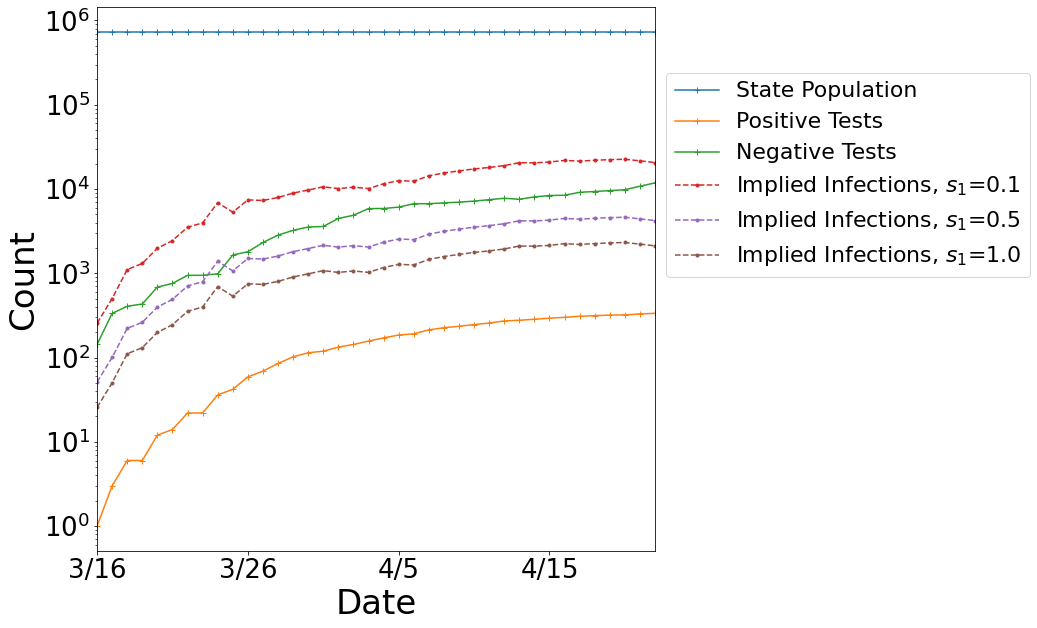

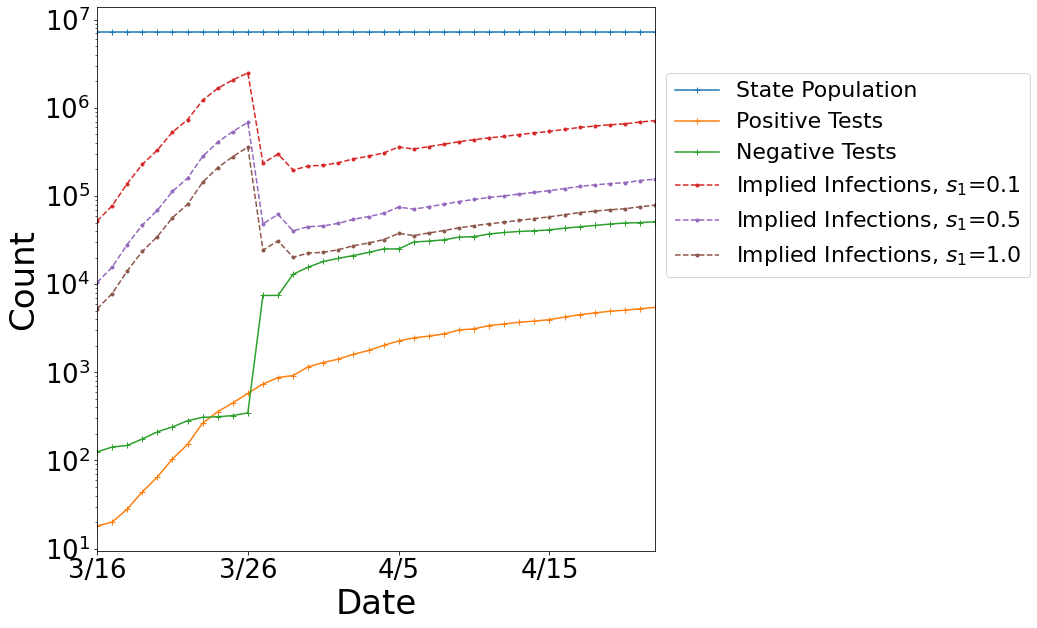

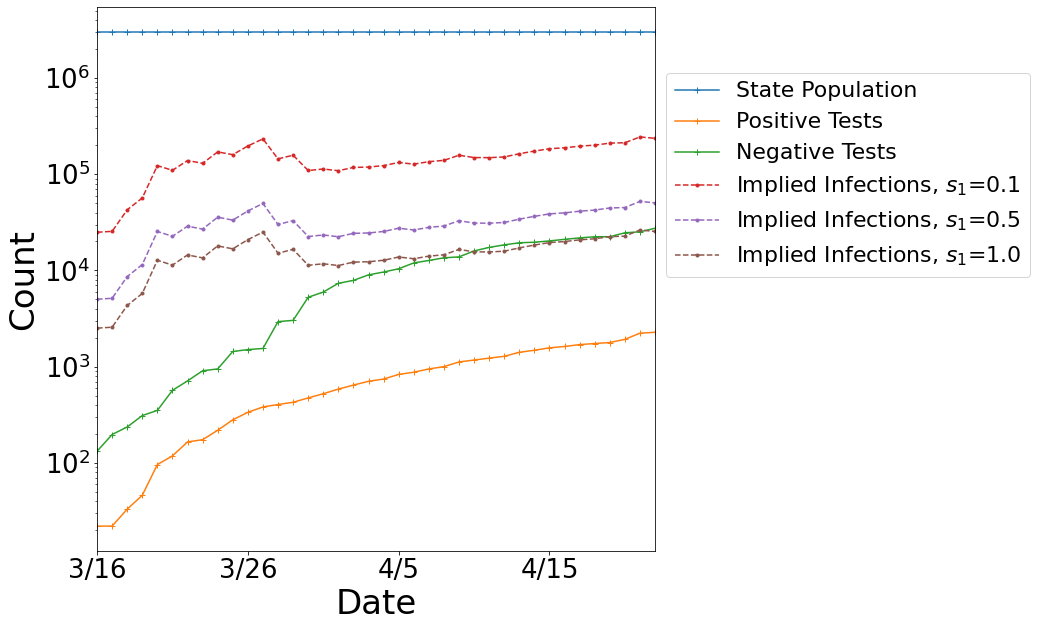

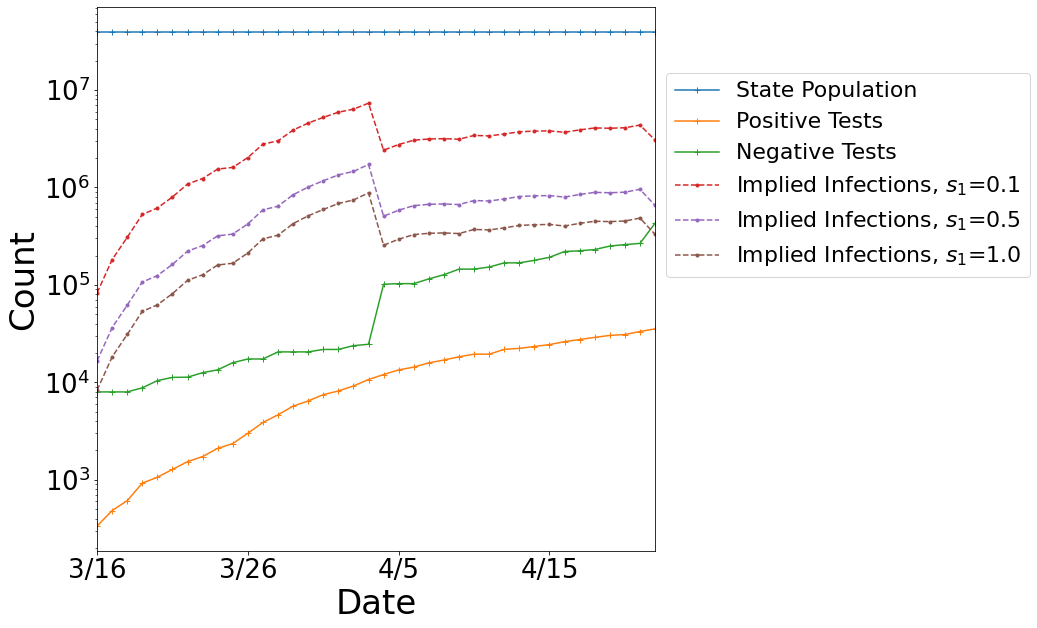

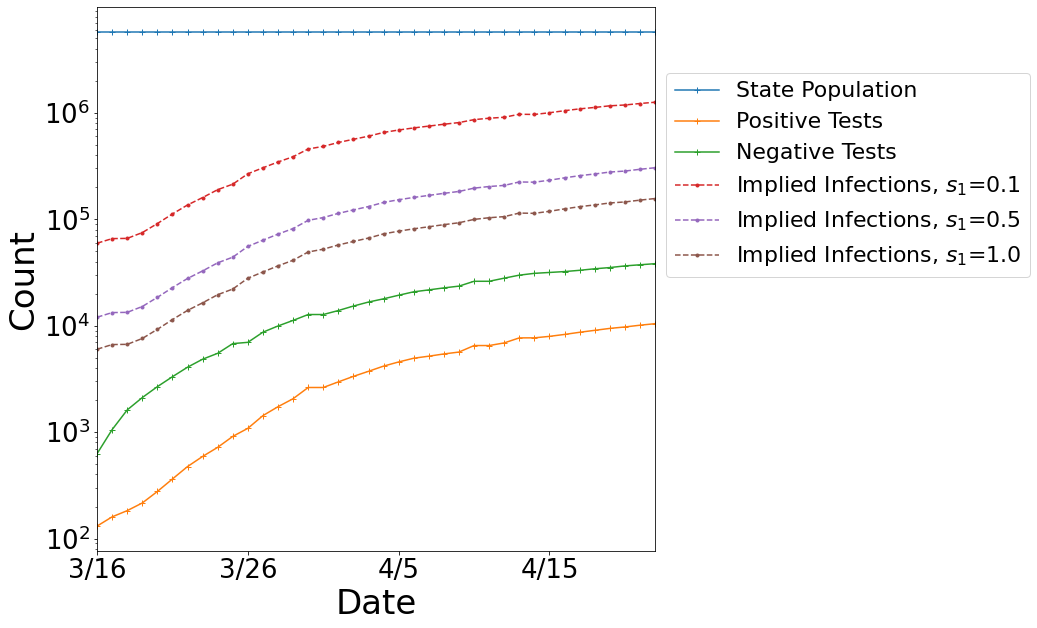

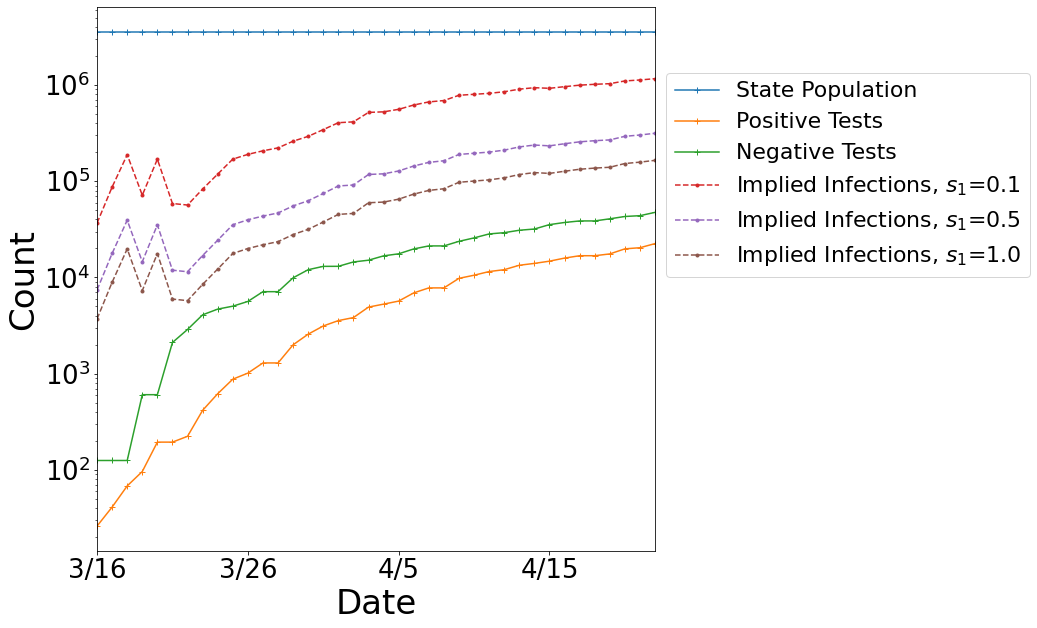

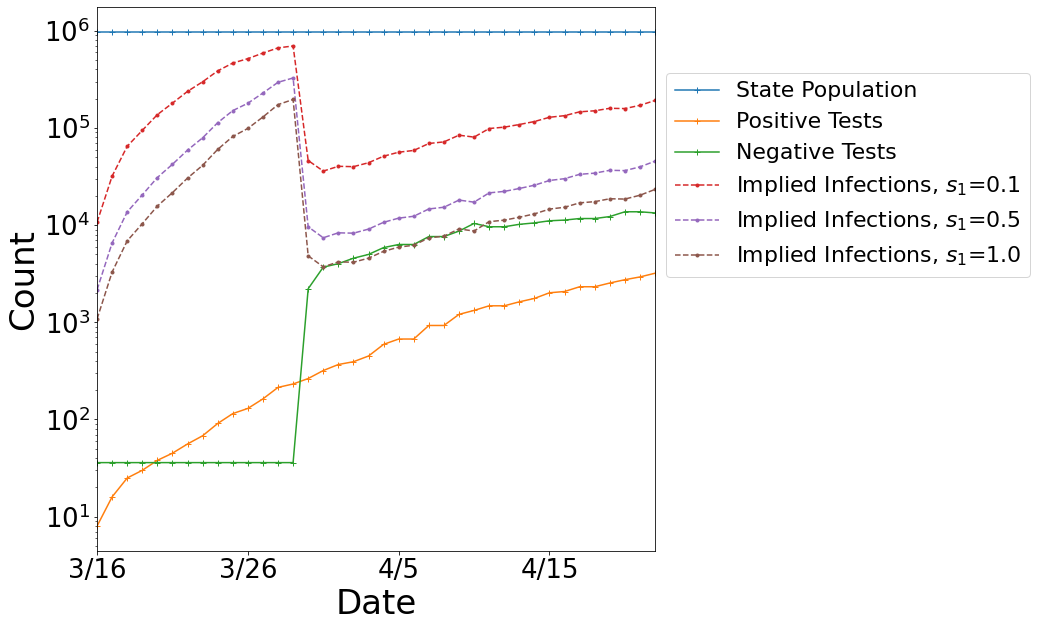

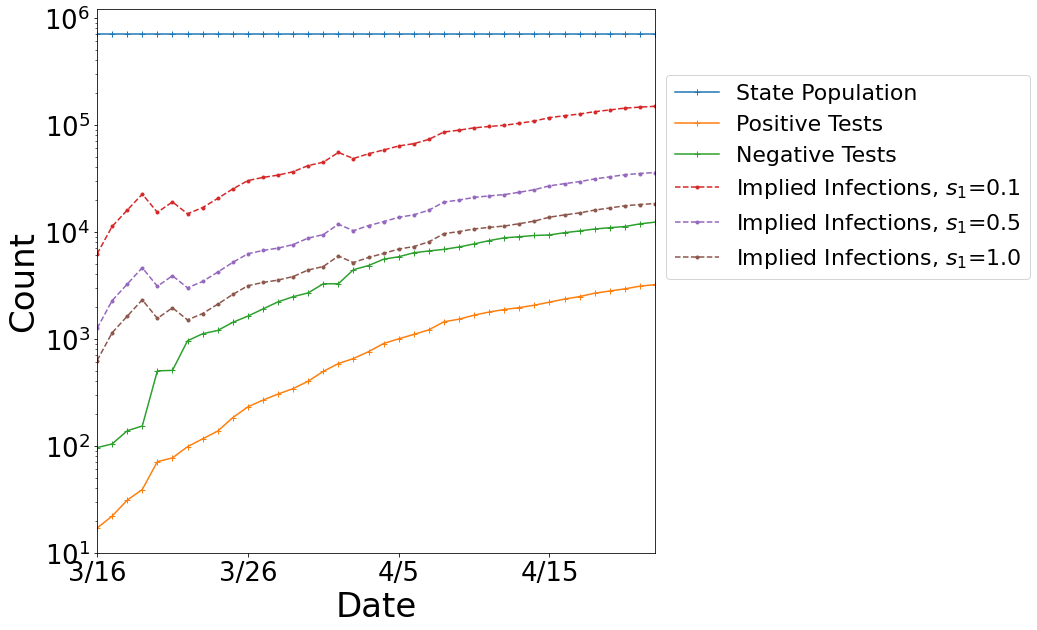

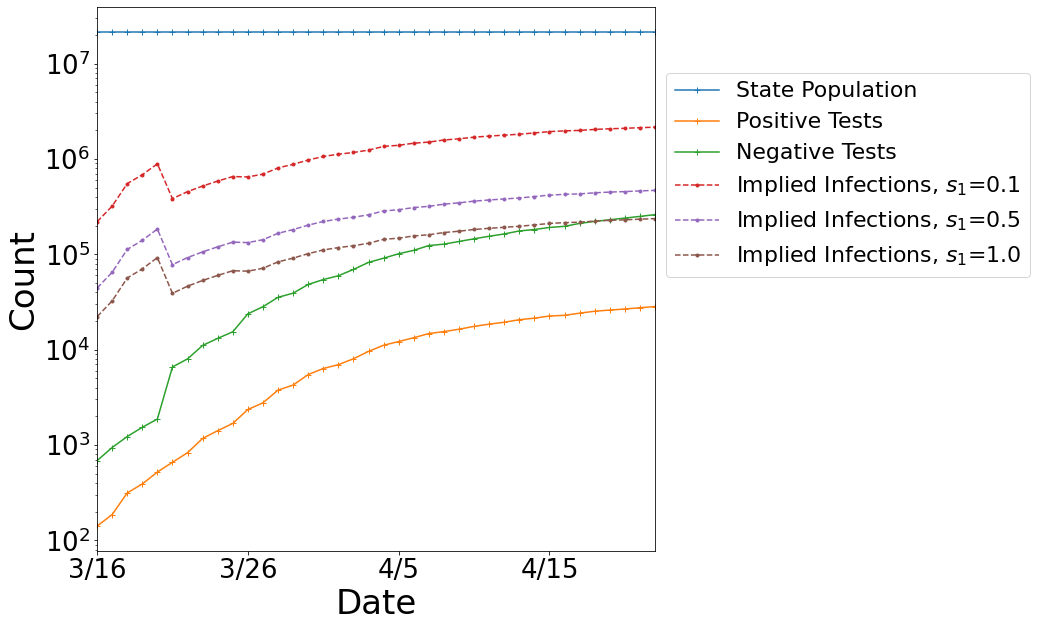

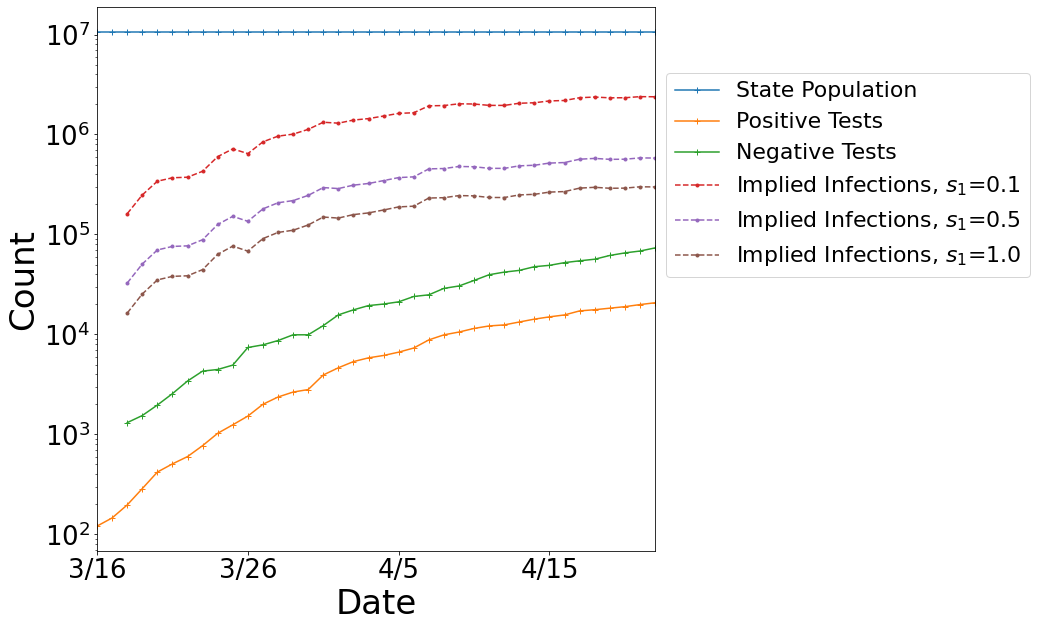

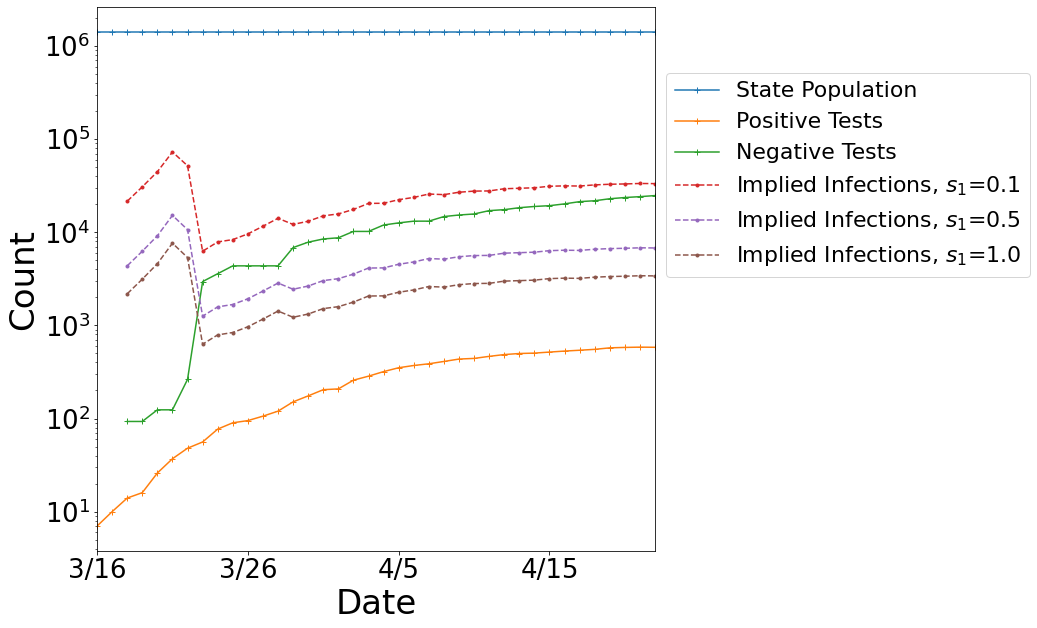

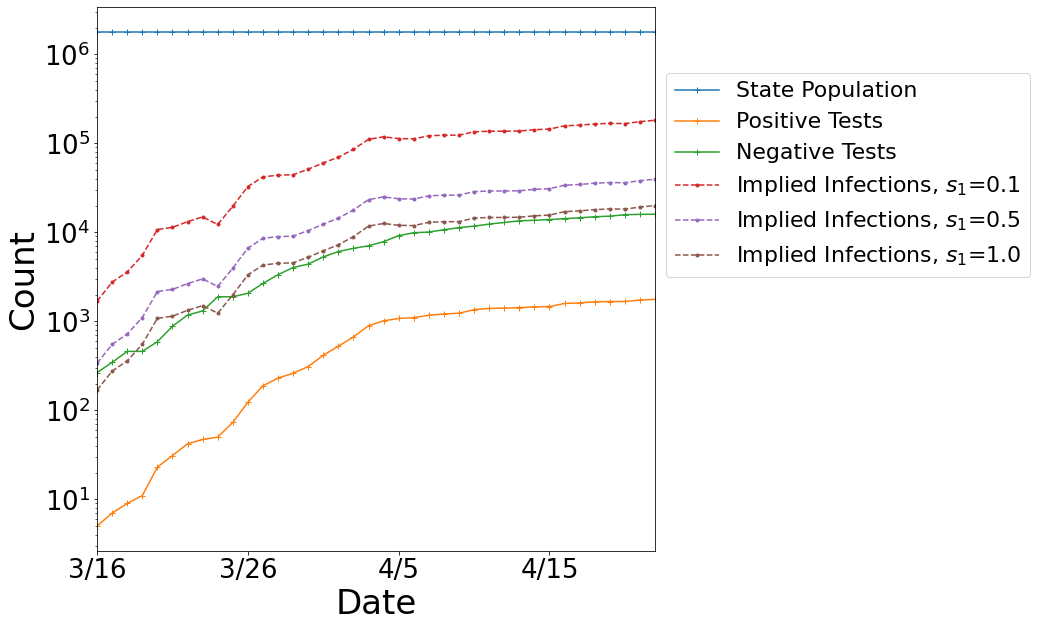

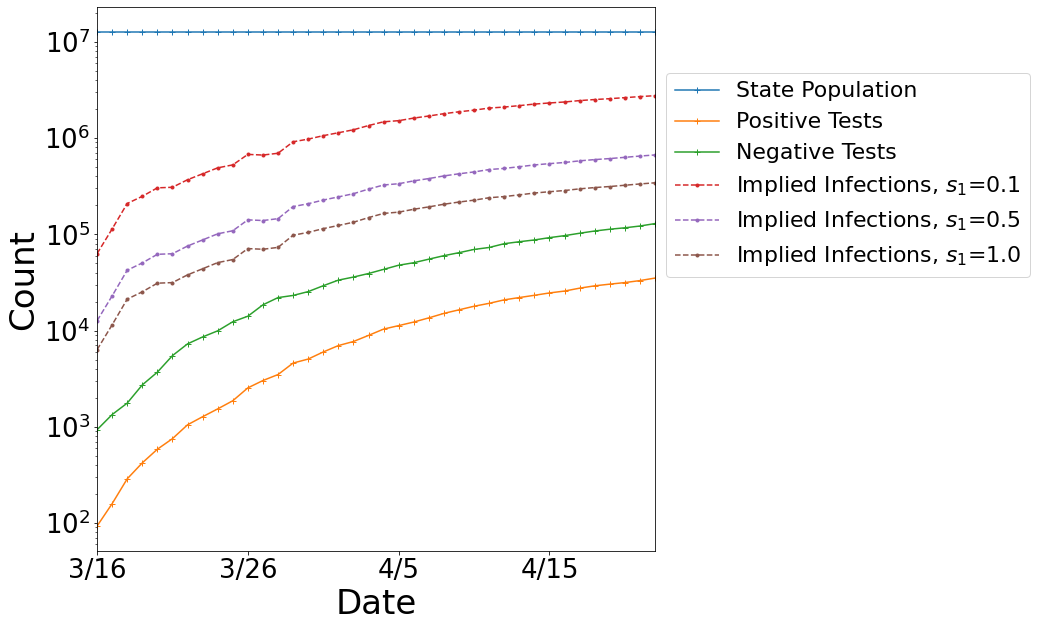

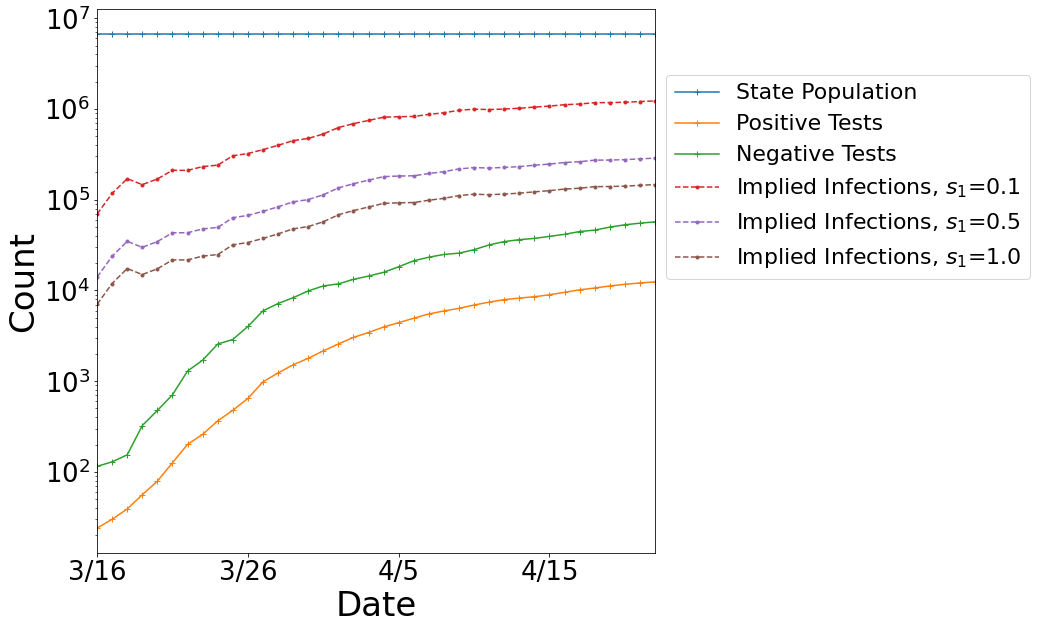

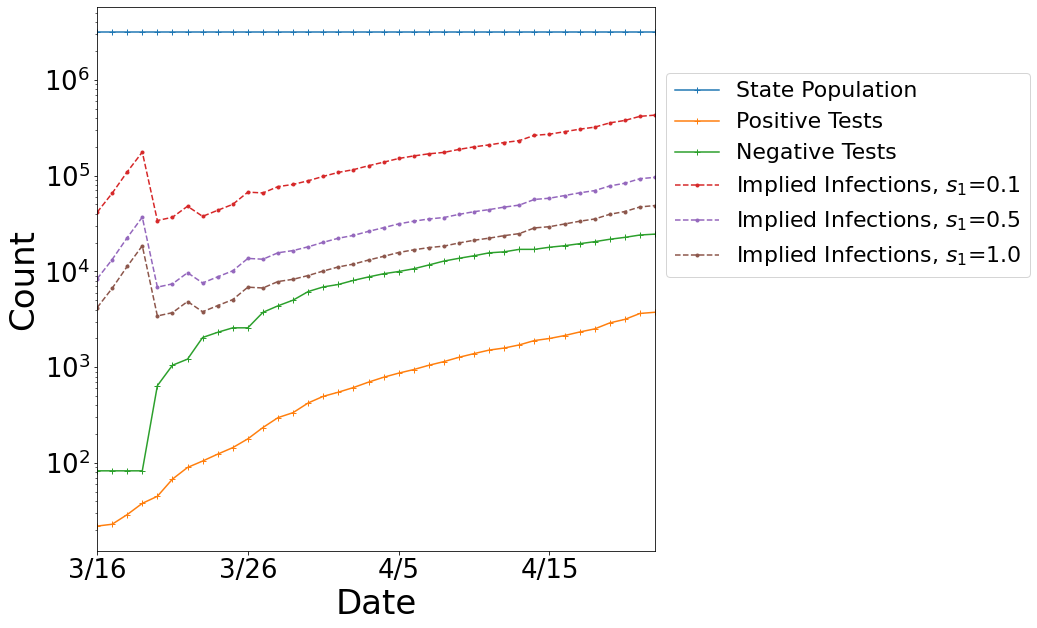

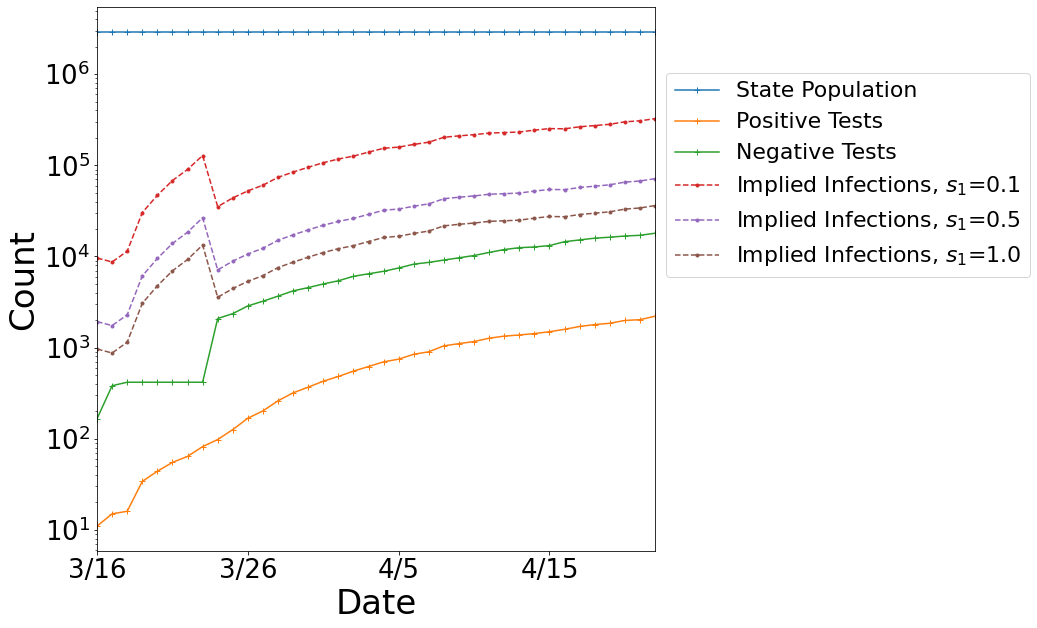

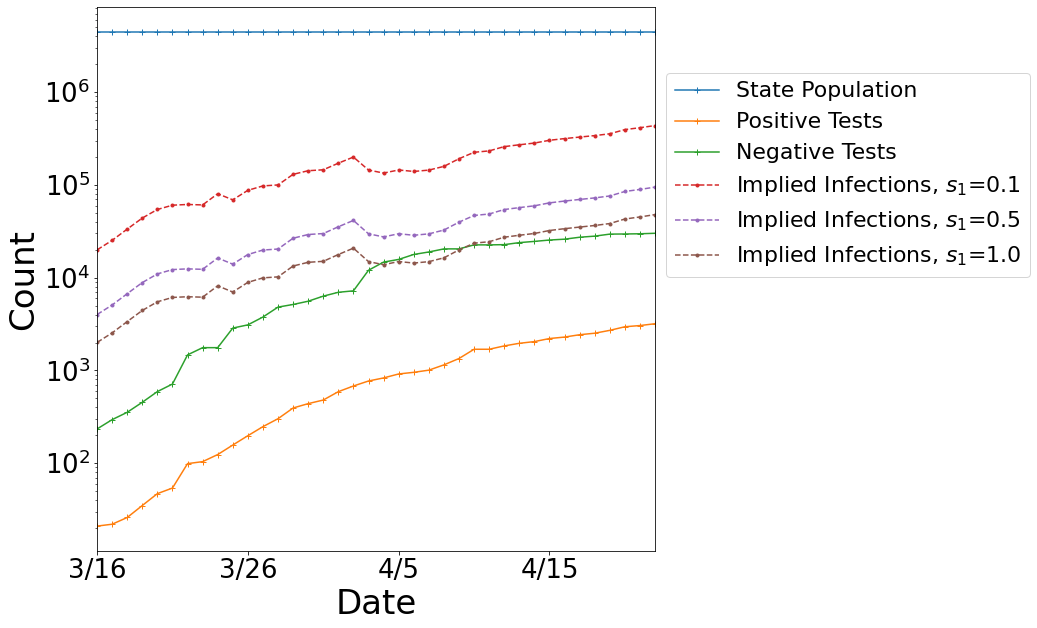

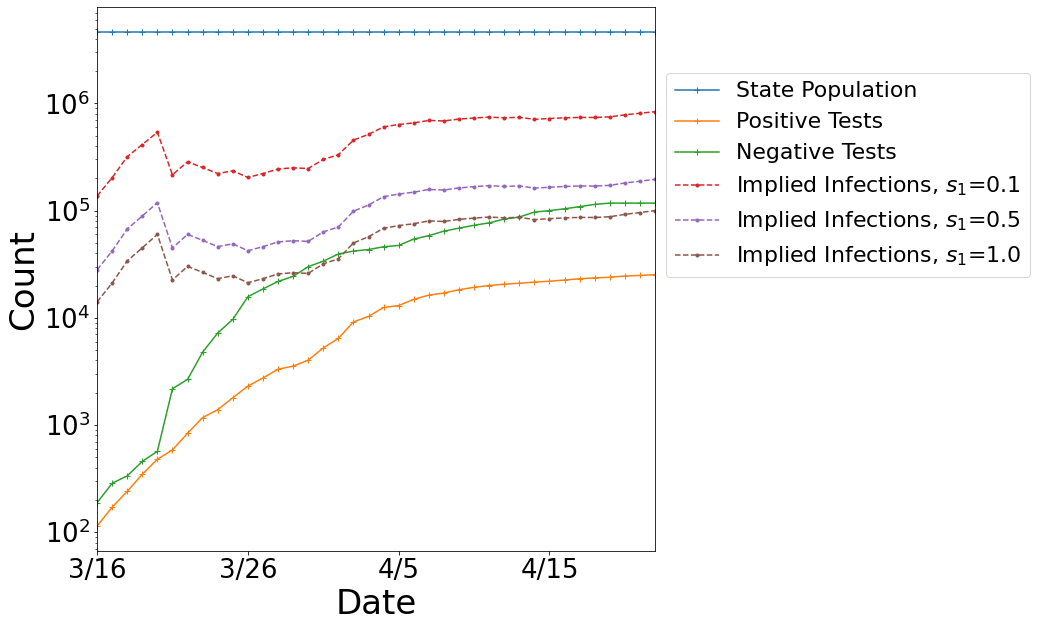

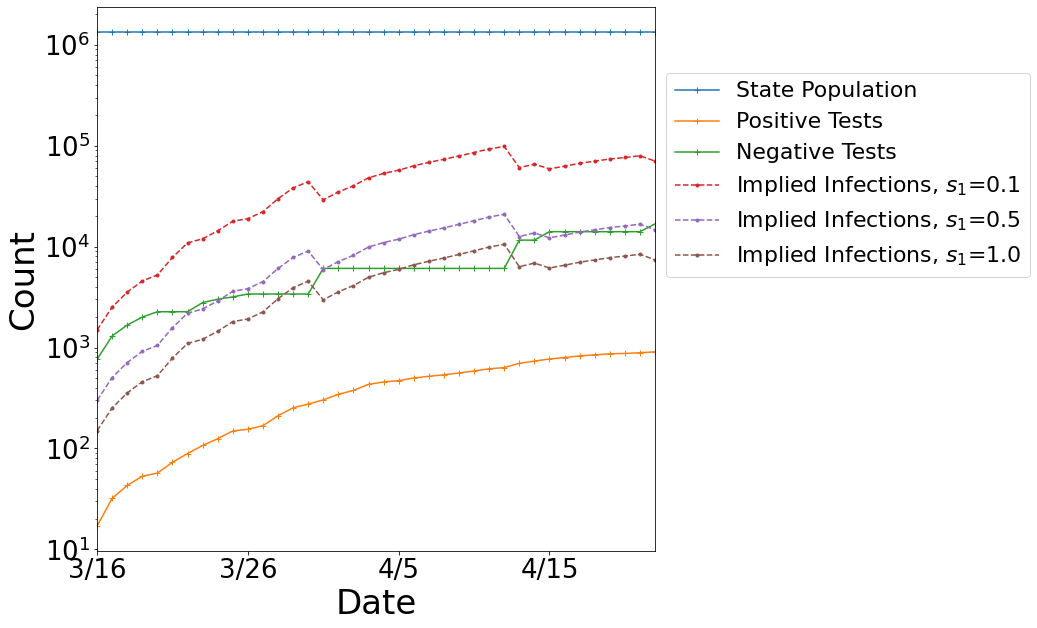

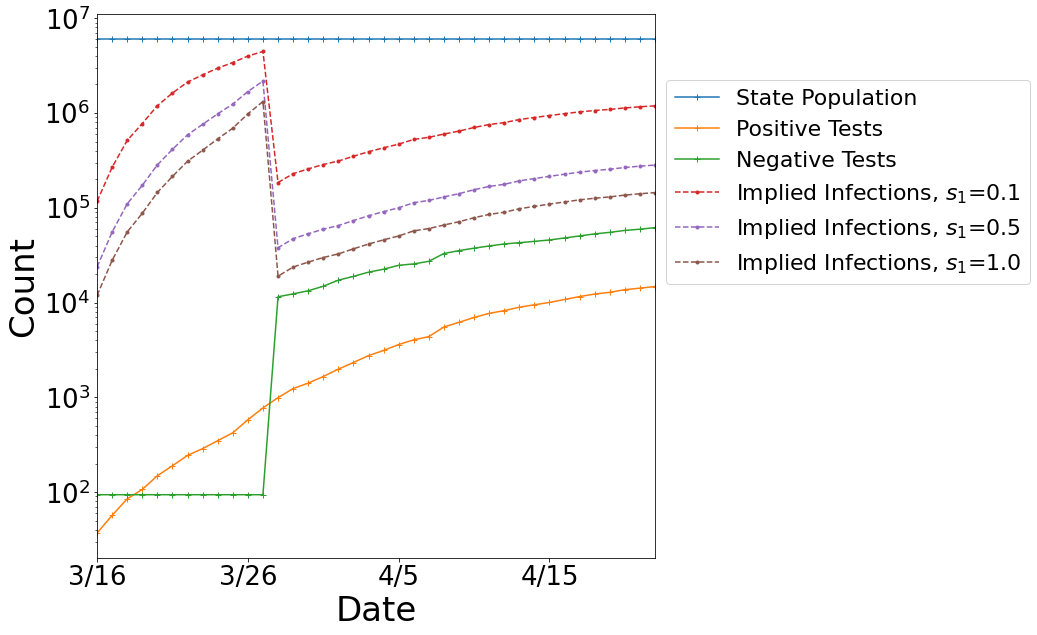

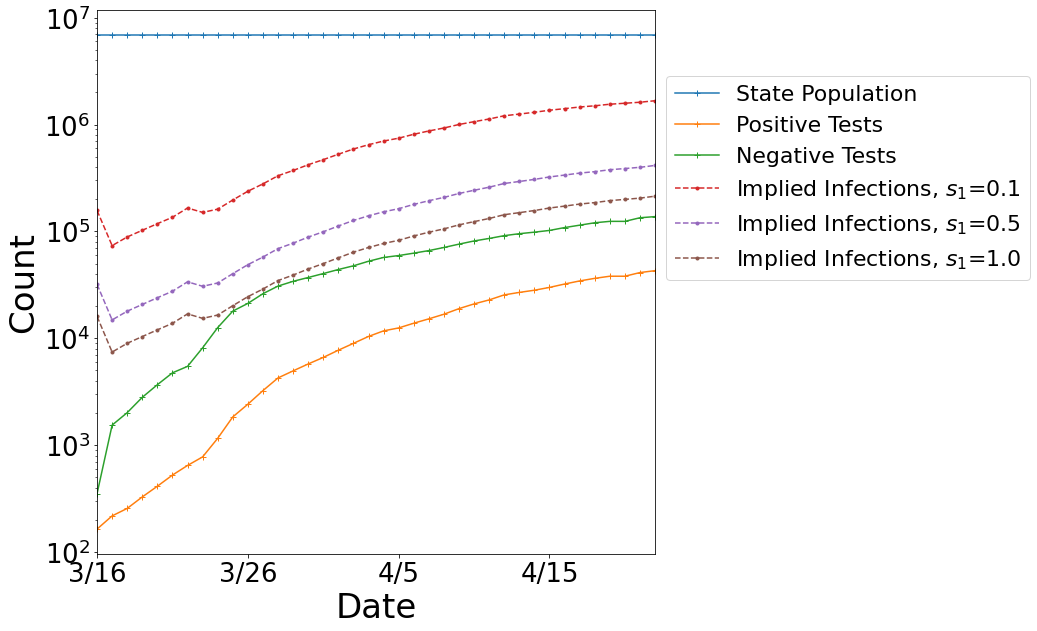

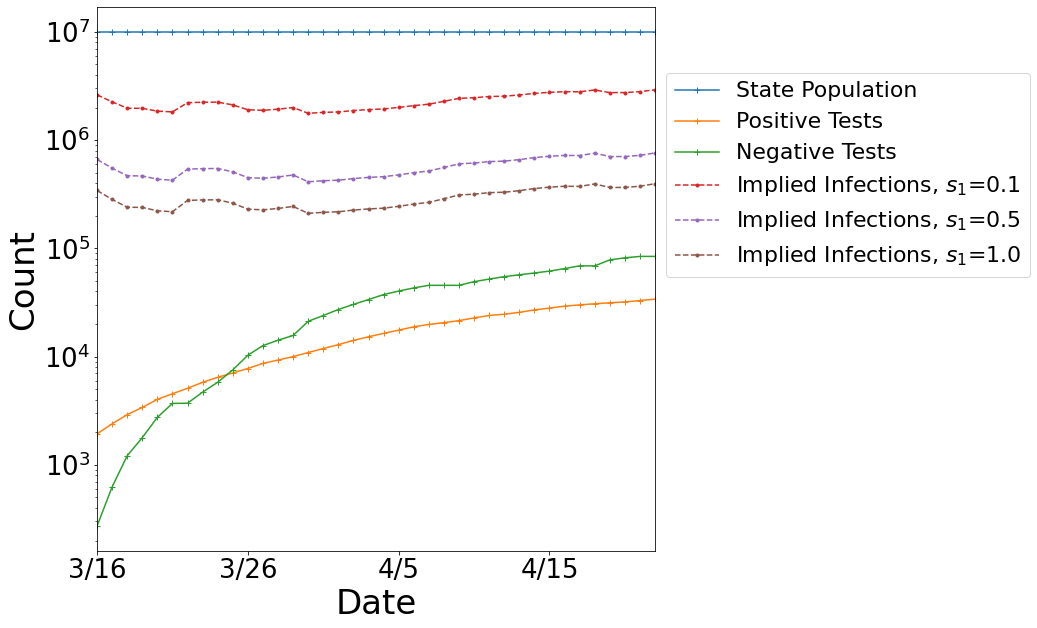

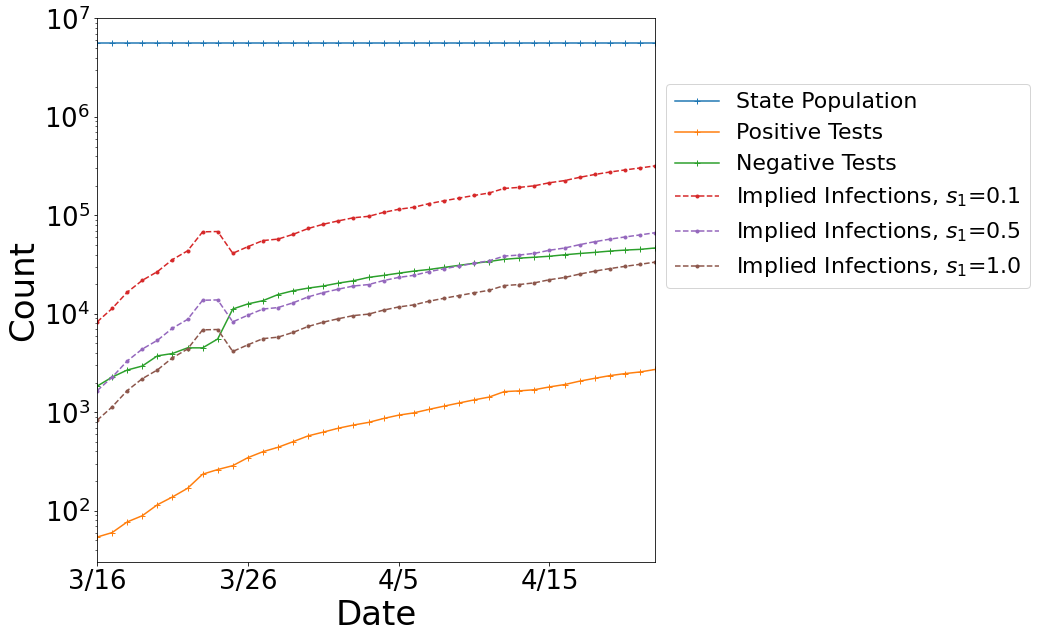

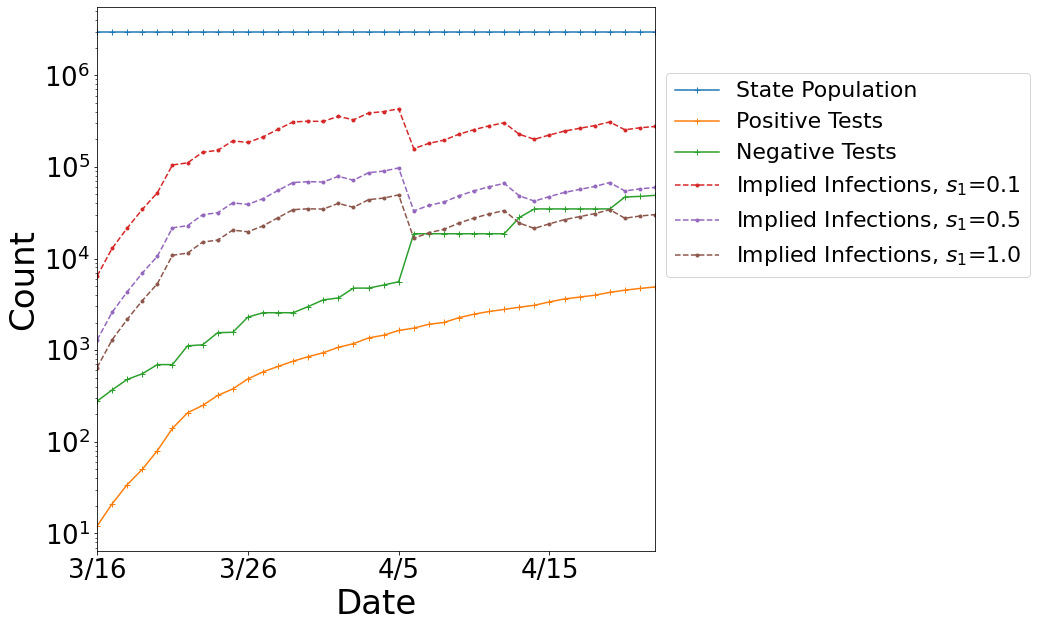

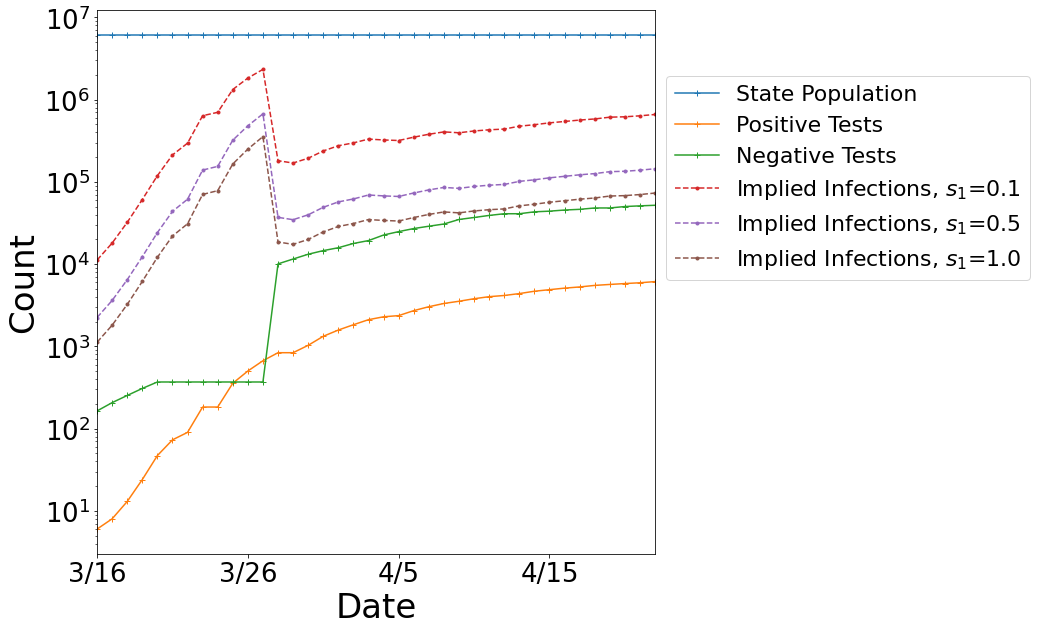

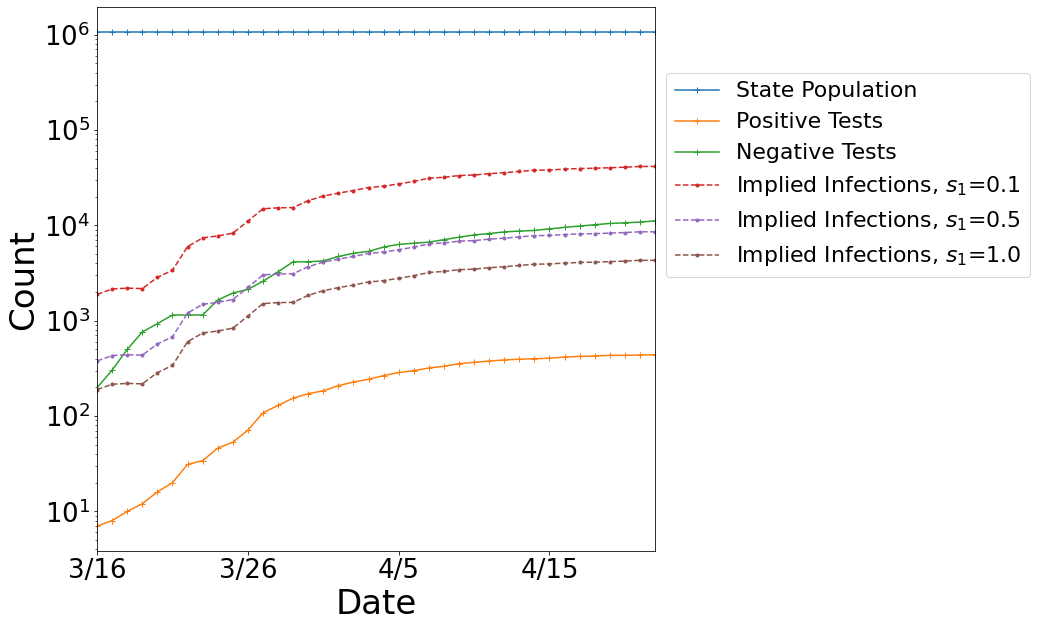

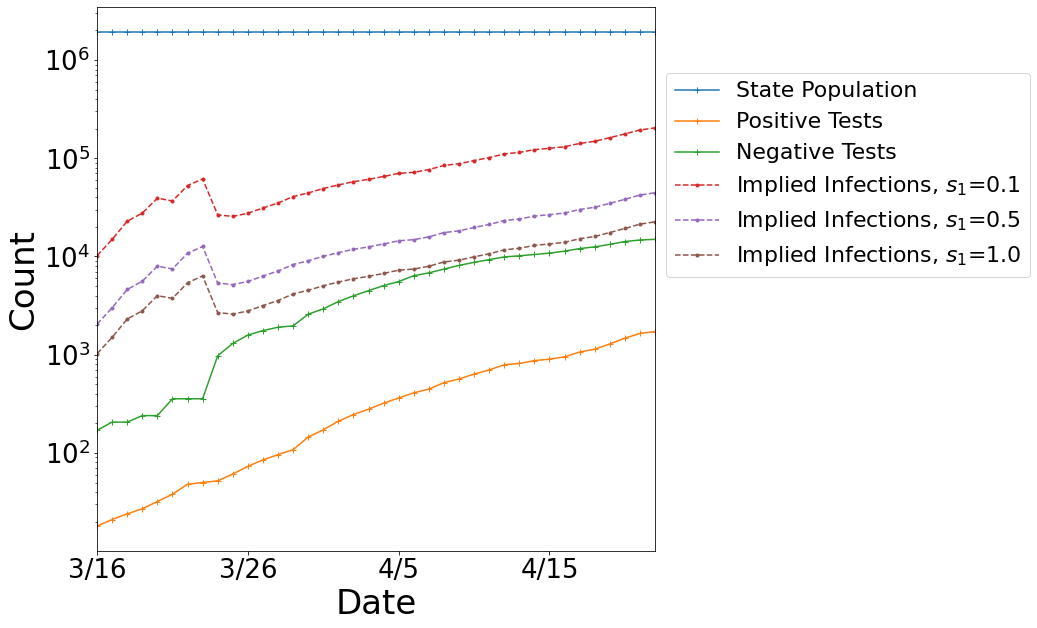

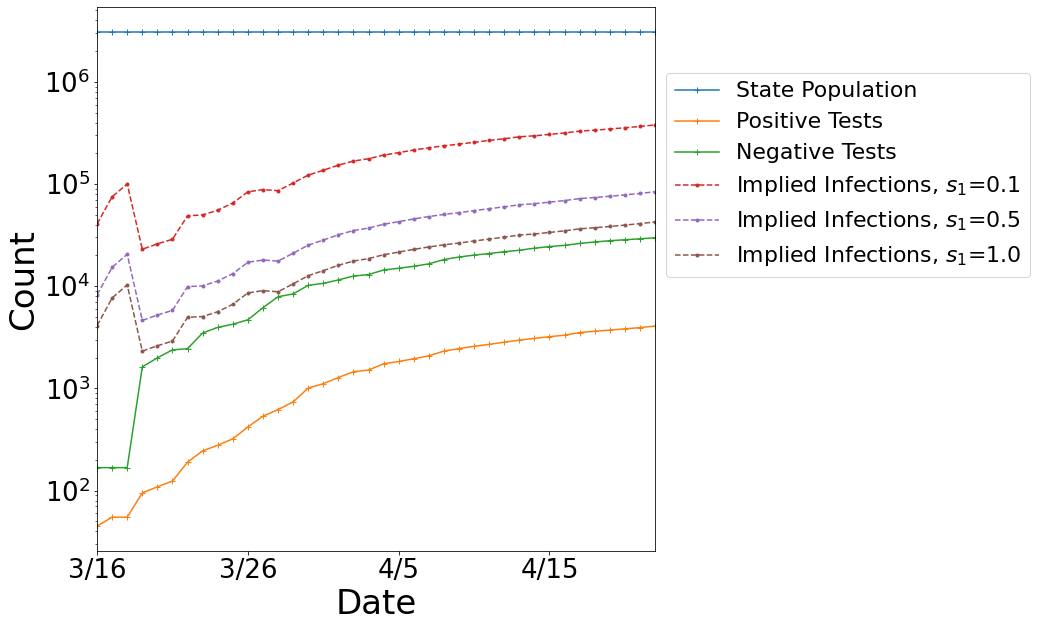

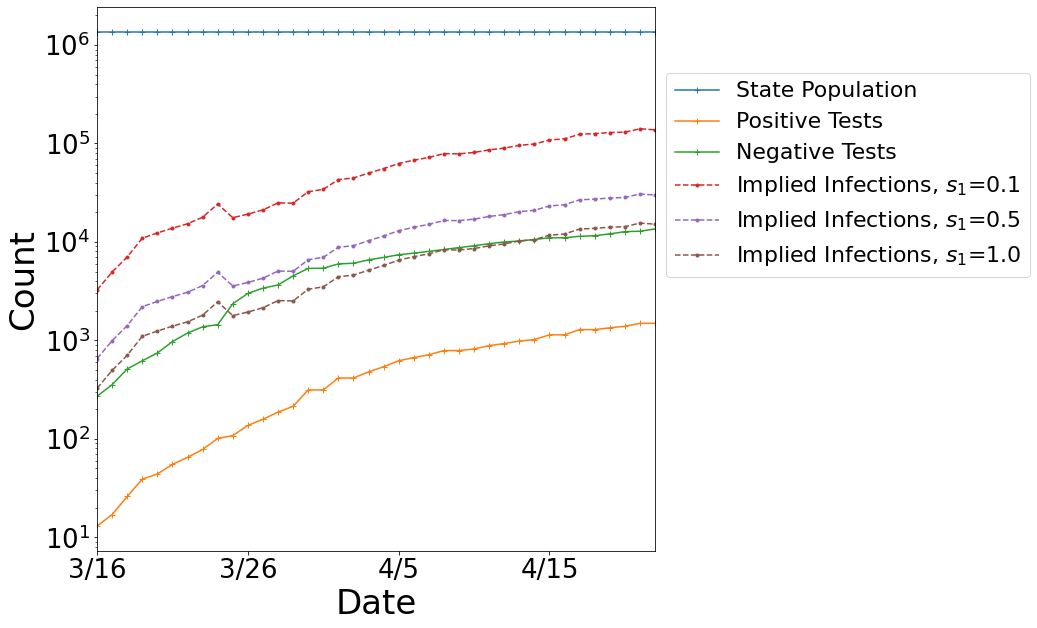

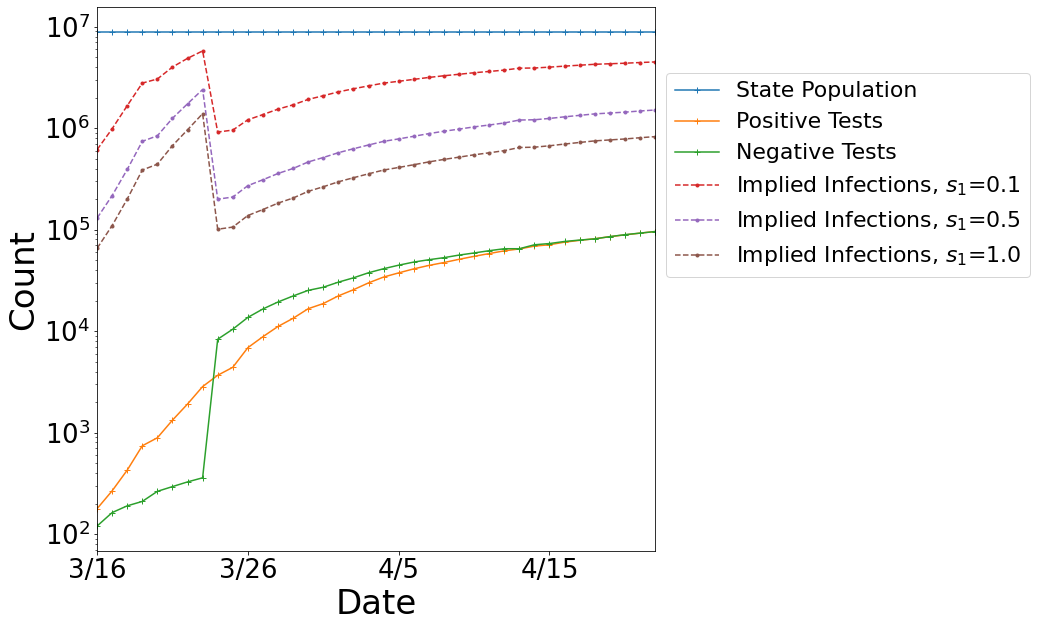

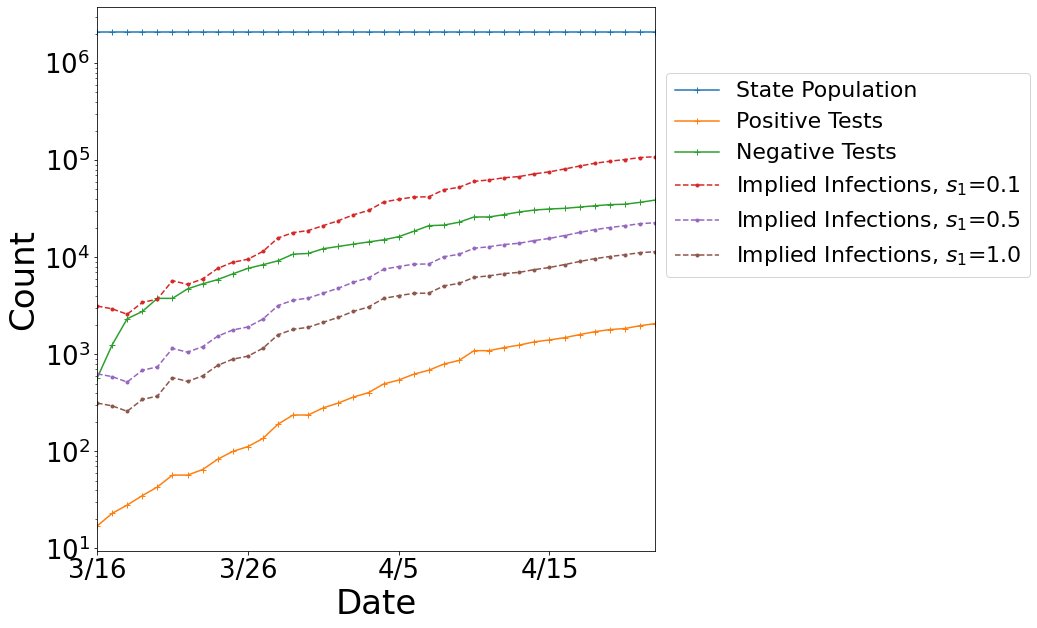

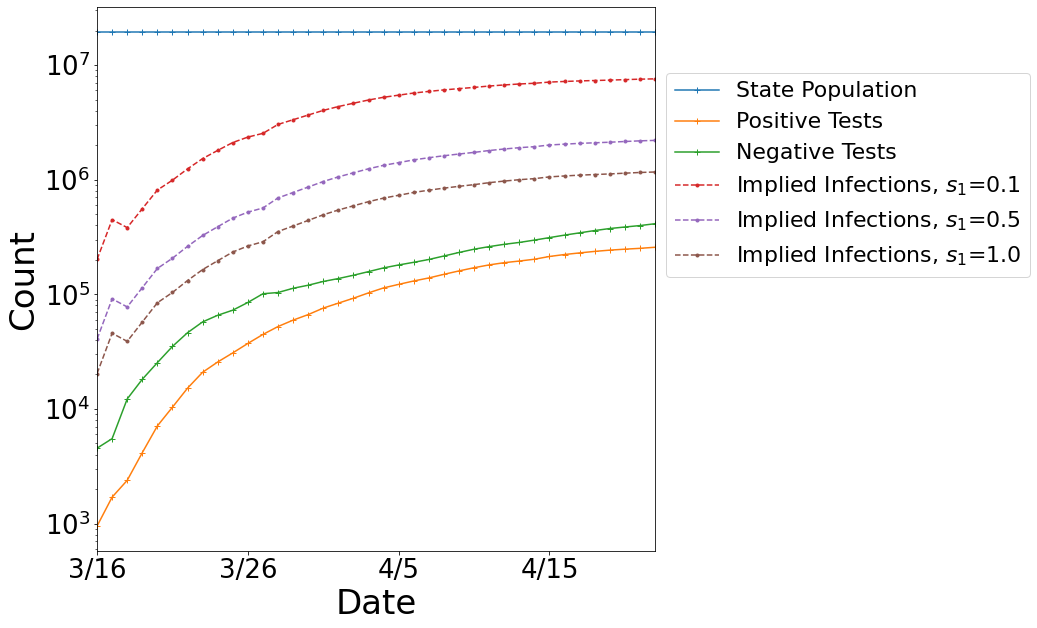

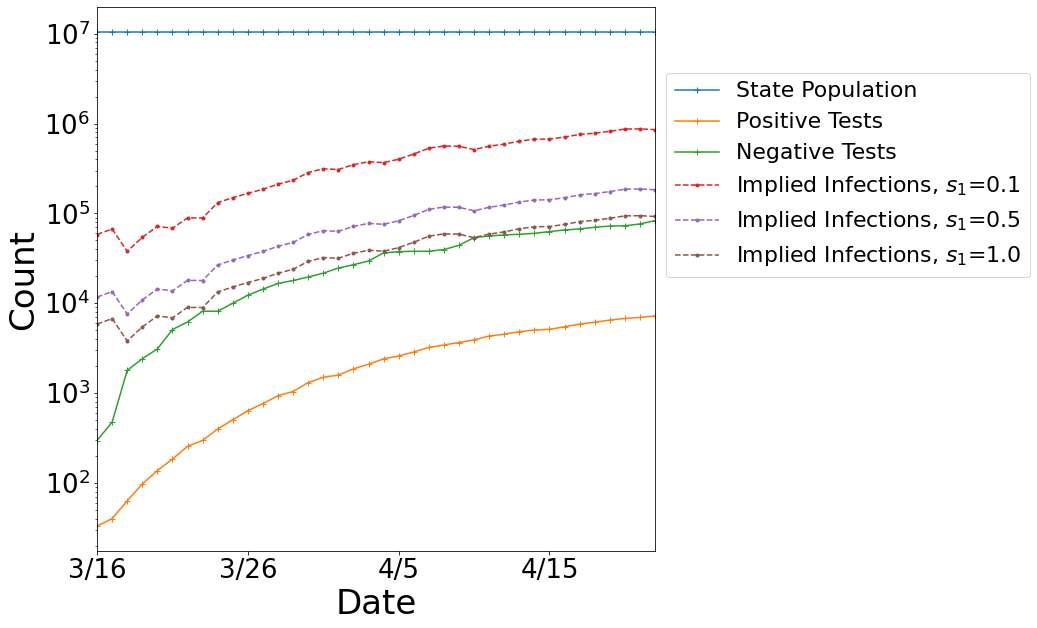

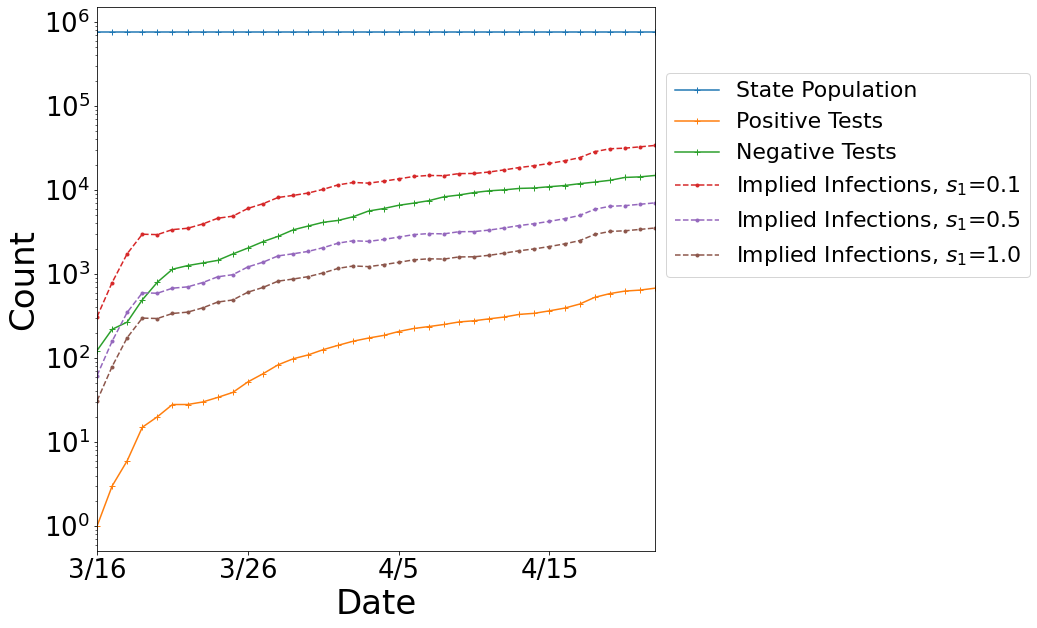

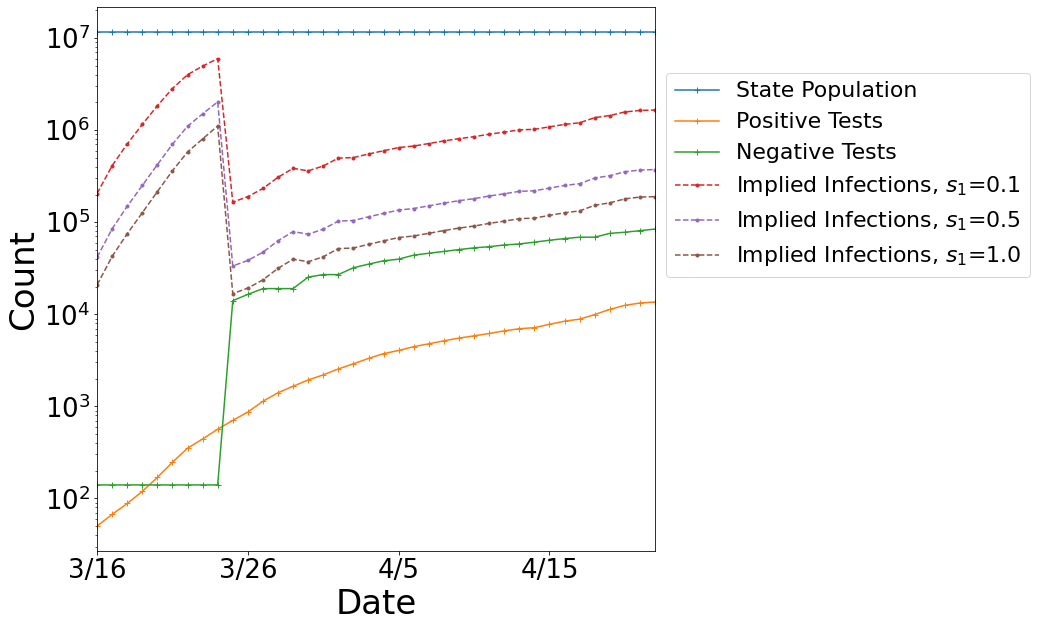

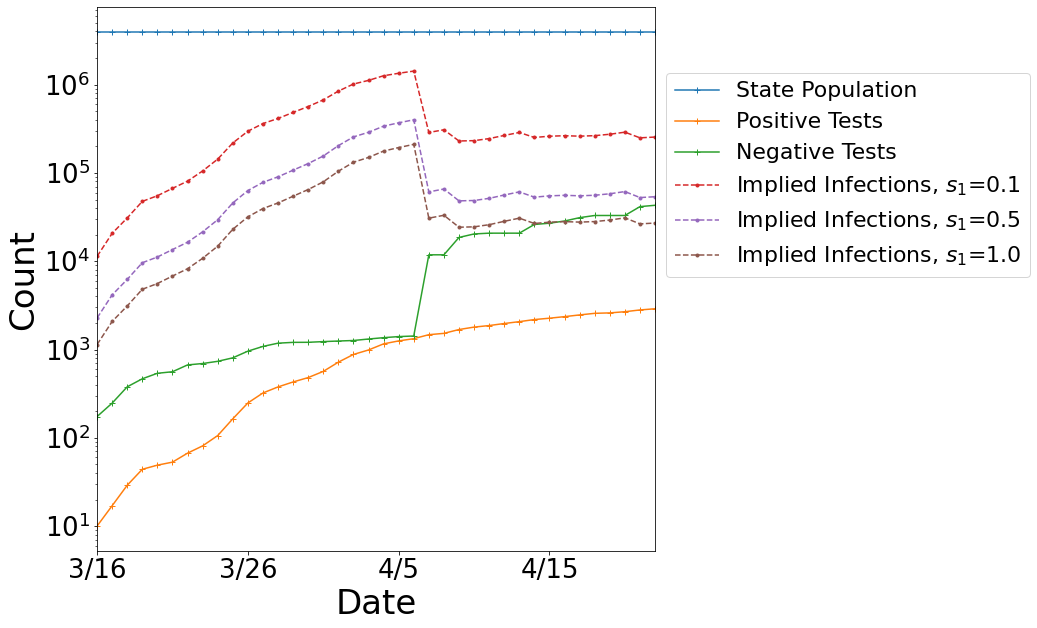

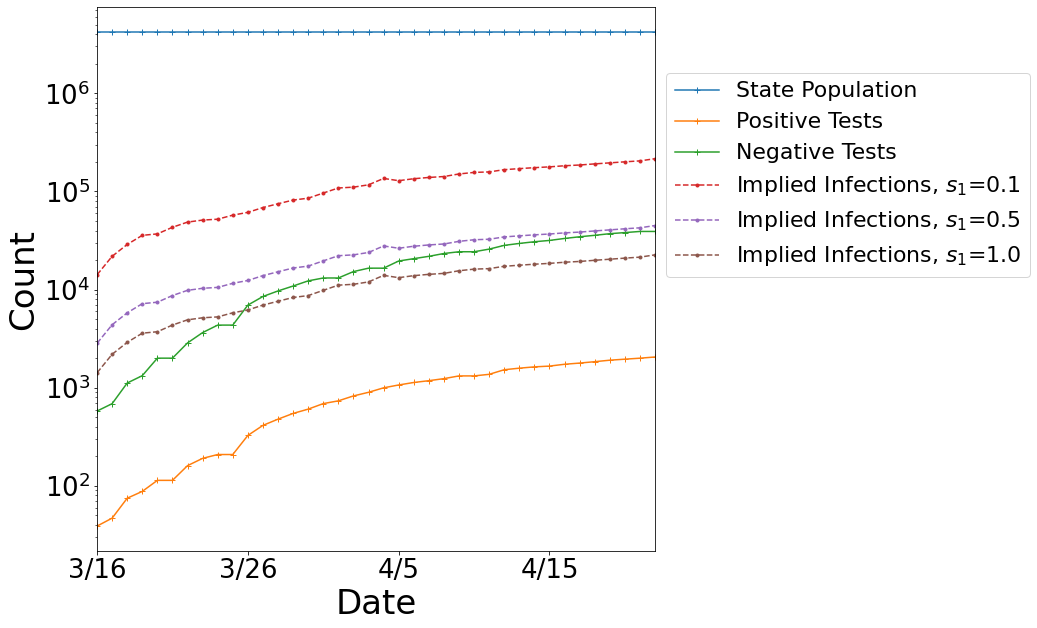

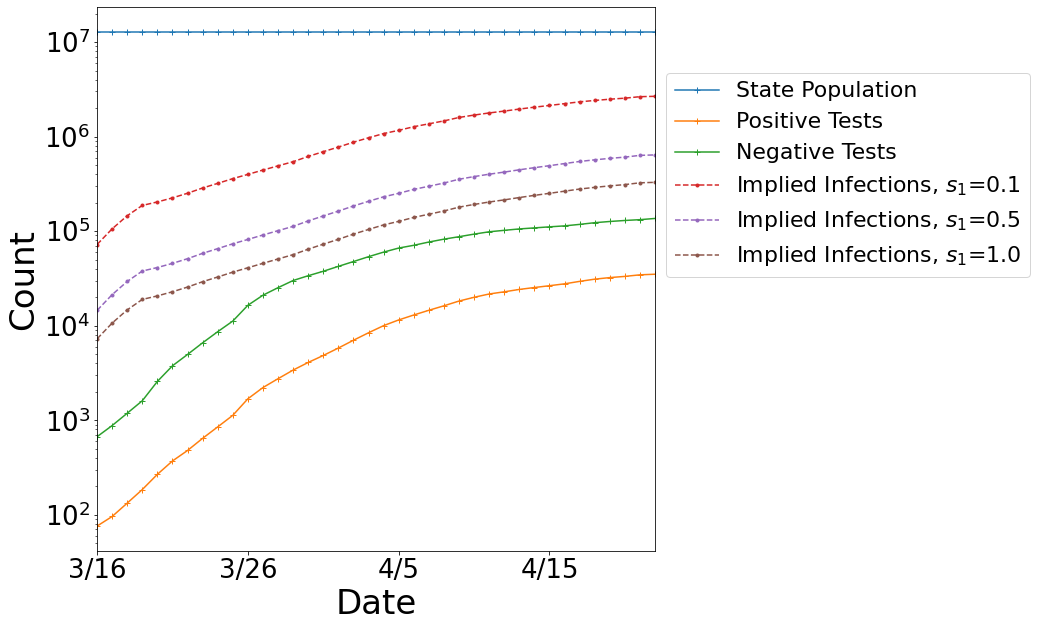

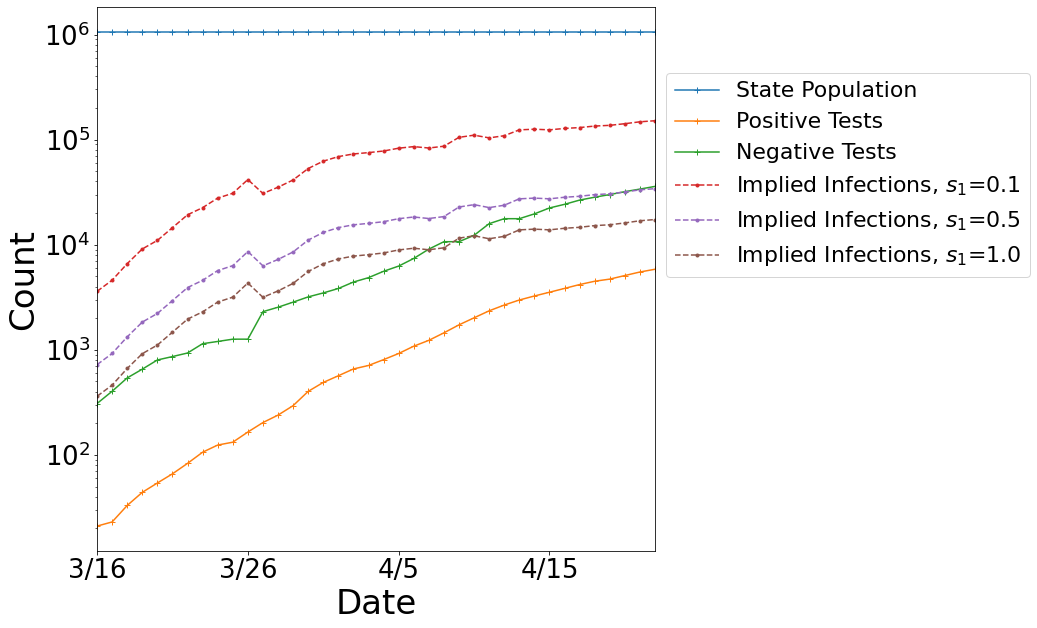

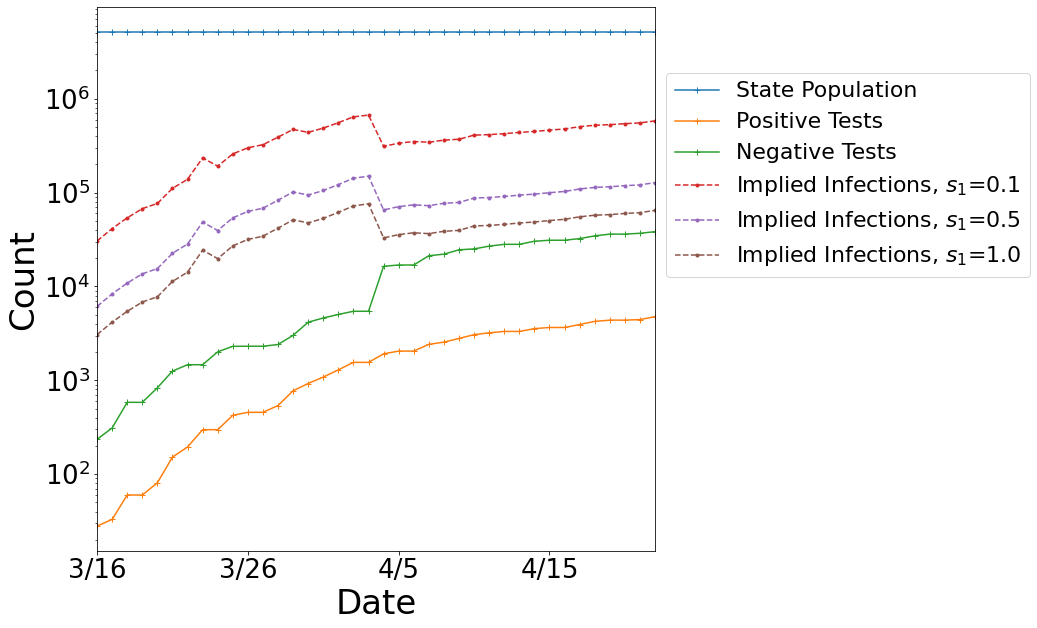

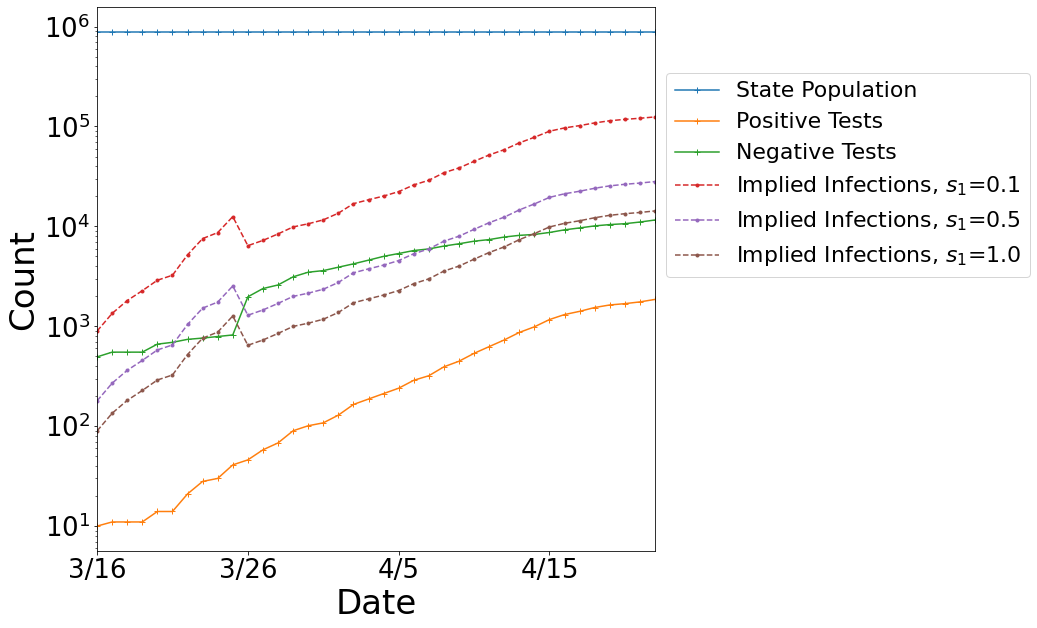

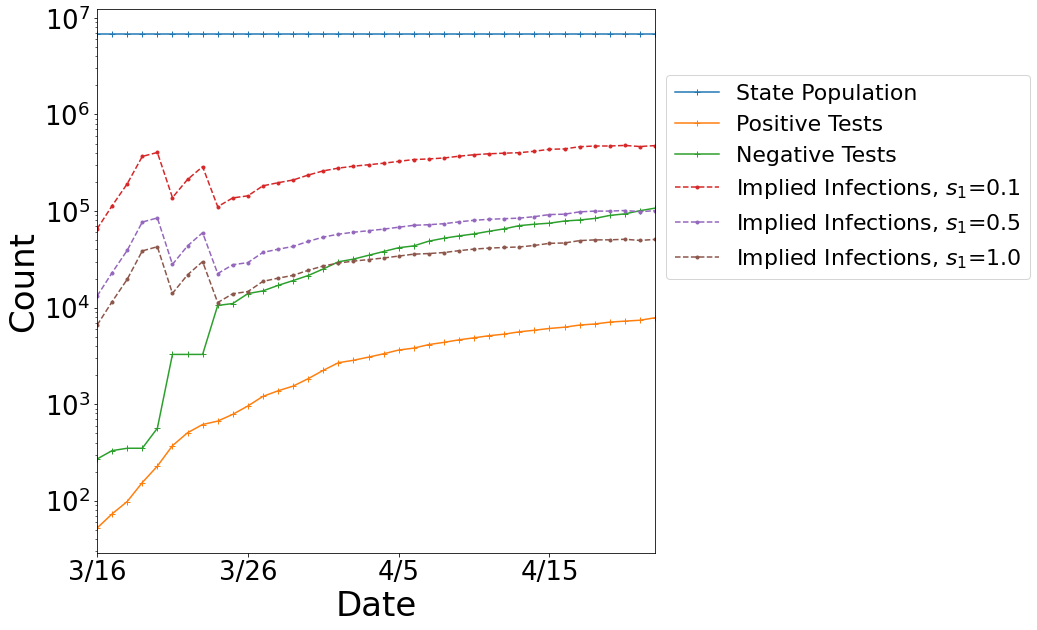

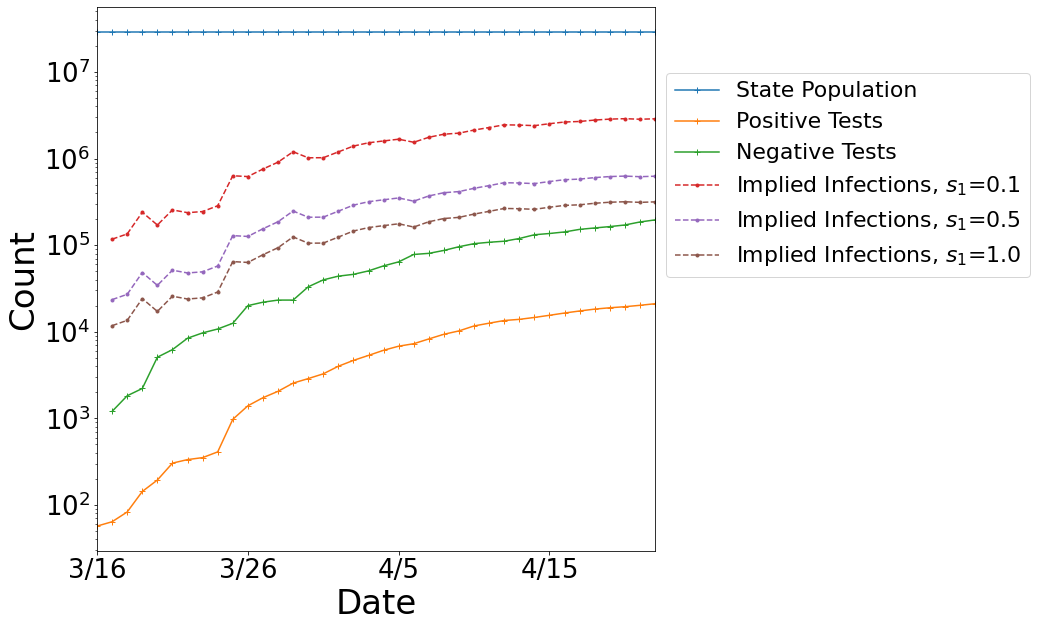

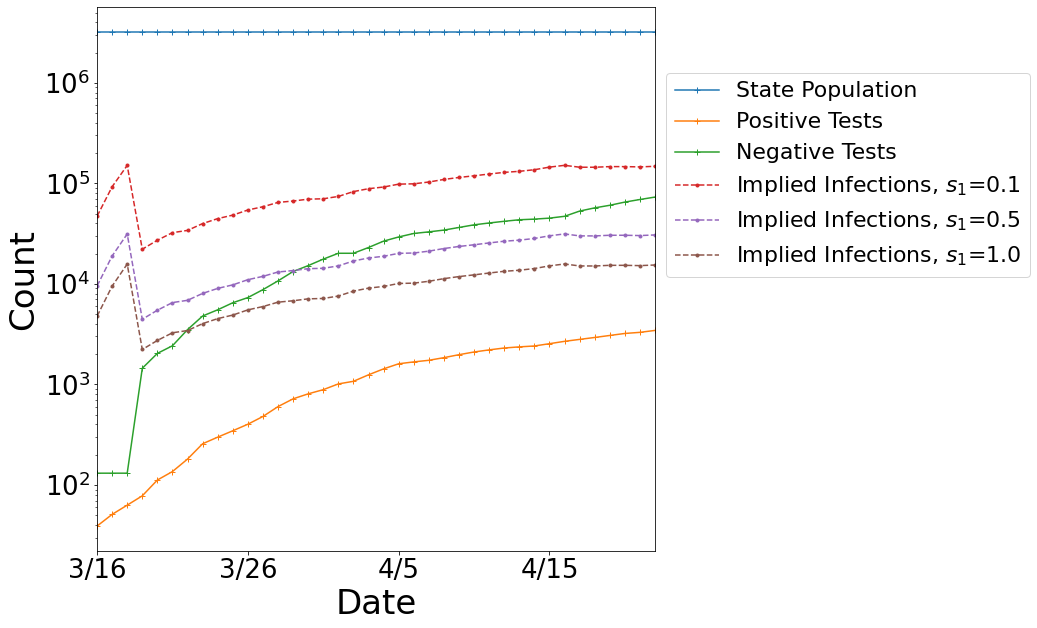

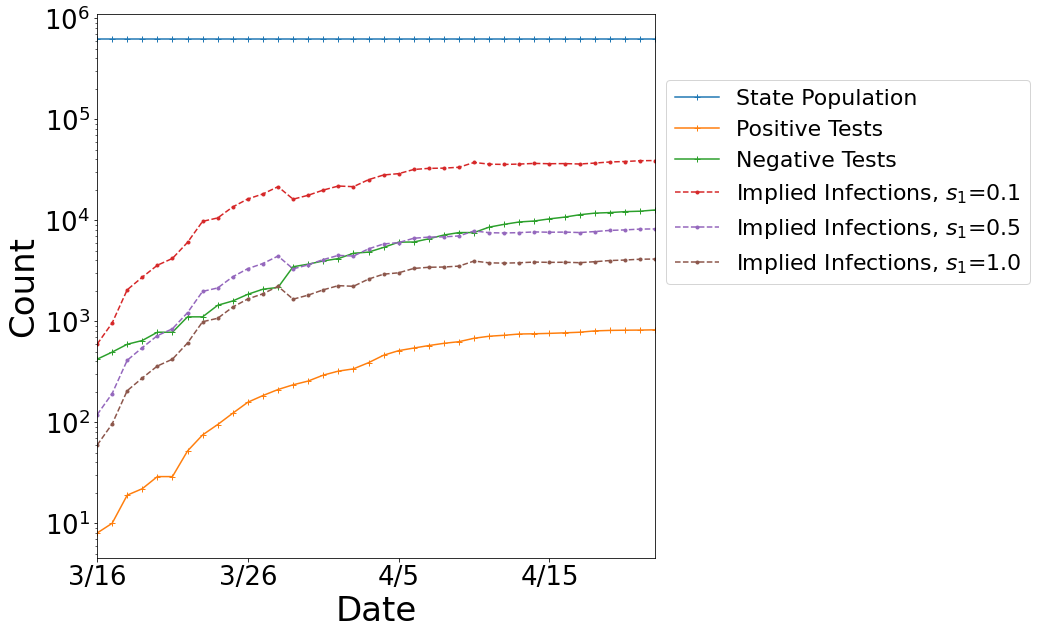

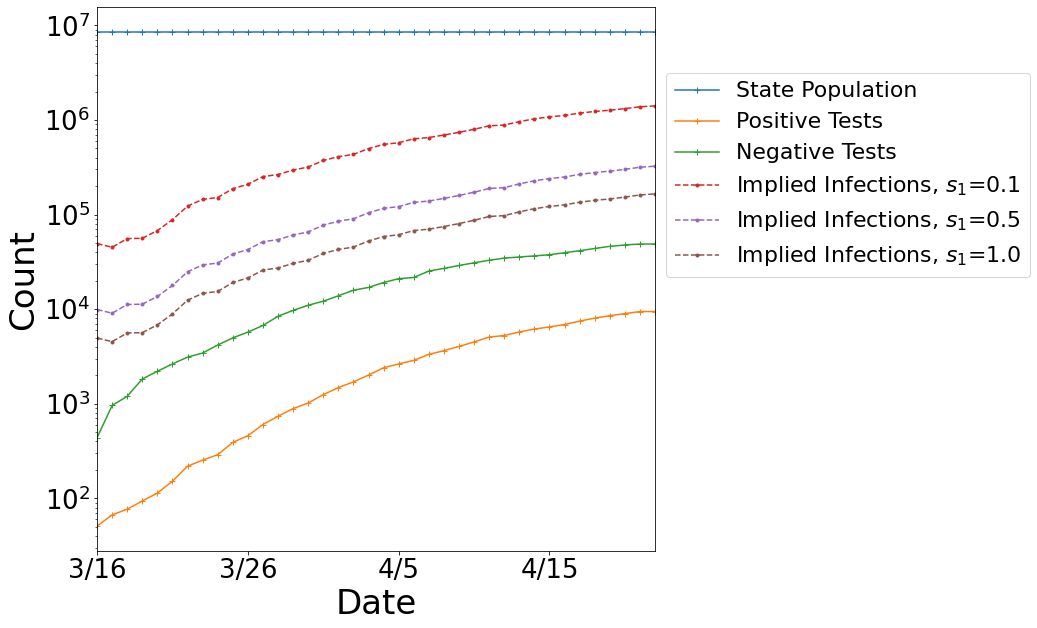

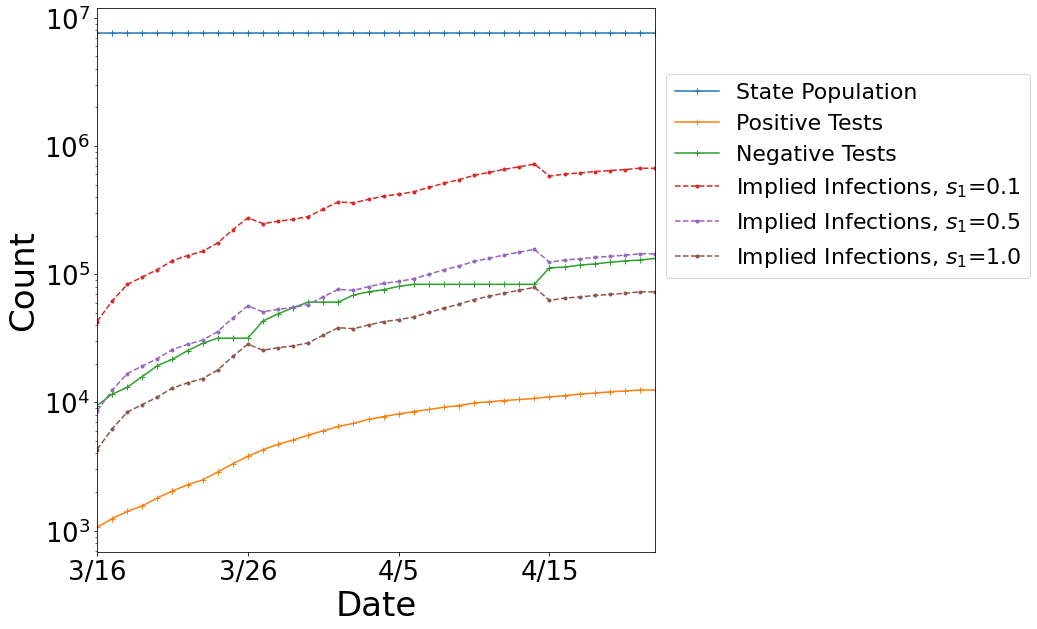

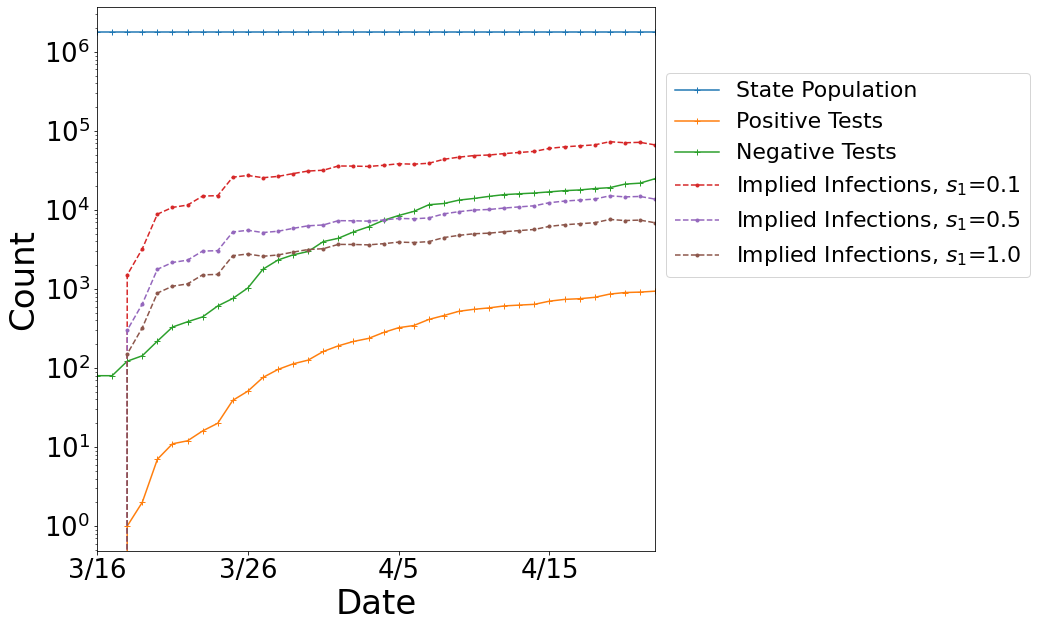

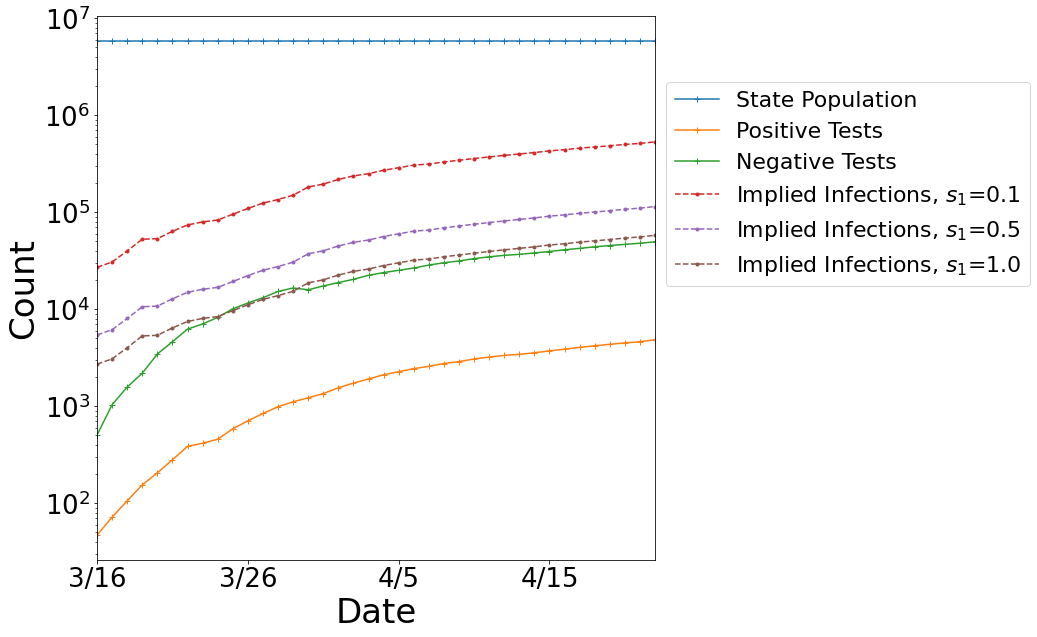

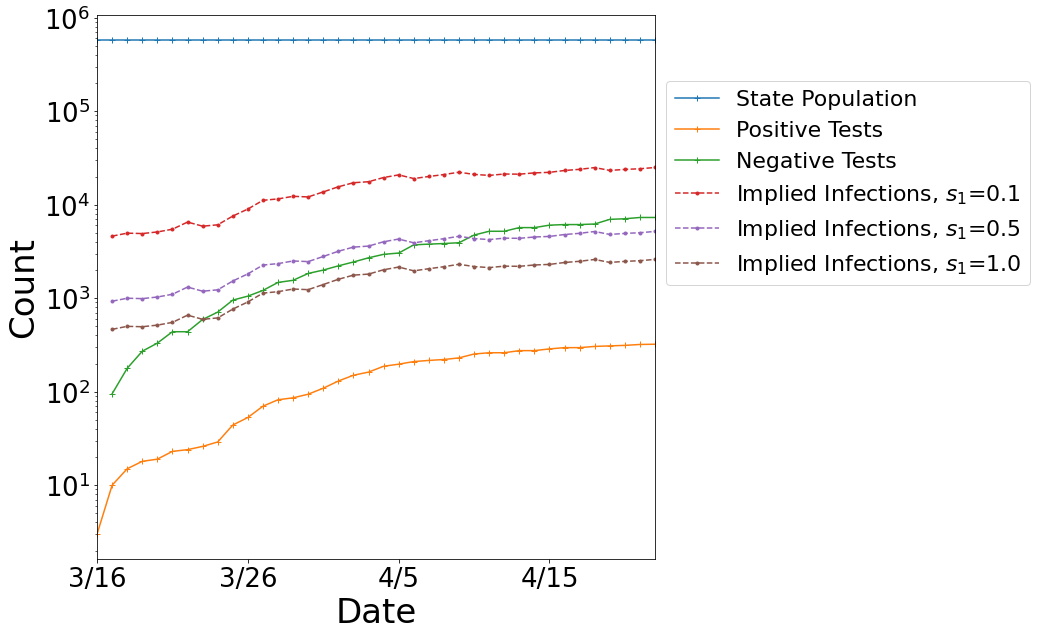

In [27]:
# Plot estimated total infections based on s0 and s1s.
# TODO: What is the purpose of this?
def plot_for_s0s_s1s(state, s0s, s1s):
    plot_pos_neg_pop(state, dates)
    for i, (s1_name, s1_key) in enumerate(s1s.items()):
        latent_totals = np.array([
            get_latent_total(state, date, s1_key/s0) for date, s0 in zip(dates, s0s)])
        print(state, s1_name, latent_totals[-1], float(latent_totals[-1]) / latent_totals[-2])
        plt.semilogy(latent_totals, label='Implied Infections, $s_1$={}'.format(s1_name), linestyle='--',
                    marker=markers[i // 4])
    finalize_plot(dates, "Count", "results/latent_cases/s0_s1/{}.pdf".format(state))

# linear trend between s0_flu and s0_cold
s0s = []
for i, date in enumerate(dates):
    s0s.append(prev_flu + i*(prev_flu+prev_cold - prev_flu)/n_dates) 

for state in state_pops.keys():
    fig = plt.figure(figsize=(10, 10))
    plot_for_s0s_s1s(state, s0s, {#'0.01': 0.01, 
                 '0.1': 0.1,
                 '0.5': 0.5,
                 '1.0': 1.0
                })

In [ ]:
"""
def plot_ros(state, cs):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    for i, (c_name, c_key) in enumerate(cs.items()):
        try: 
            latent_totals = np.array([
                get_latent_total(state, date, c_key(j)) for j, date in enumerate(dates)])
        except:
            latent_totals = np.array([
                get_latent_total(state, date, c_key) for j, date in enumerate(dates)])
        plt.plot((latent_totals[1:]-latent_totals[:-1])/latent_totals[:-1], label='{}'.format(c_name), linestyle='--',
                    marker=markers[i // 4])
    finalize_plot(dates, "$$R_0$$", "results/r0s/cold_flu_{}.pdf".format(state))
    
fig = plt.figure(figsize=(10, 10))
        plot_ros(state, {'Required Symptoms: Cold': 5, 
                     'Required Symptoms: Flu': 100,
                     'Required Symptoms: Bad Flu': 500,
                     'Required Symptoms: Flu->Cold': lambda j: logistic(0, len(dates)-1, 100, 5, j),
                     'Required Symptoms: Bad Flu->Flu': lambda j: logistic(0, len(dates)-1, 500, 100, j),
                    })
"""